<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Proyecto Final</center>

# Modelizacion del consumo de recursos del equipamiento de red de un ISP

## Nombres:
- Efrain Gonzalez
- Pablo Sagrera

## Tabla de Contenidos
- [Introducción](#Introducción)
- [Recopilación de los Datos](#Recopilación)
- [Prerequisitos](#Prerequisitos)
    - [Instalación de dependencias](#dependencias)
    - [Importación de librerías](#librerias)
- [Carga del dataframe](#Carga)
- [Preprocesado de los datos](#Preprocesado)
    - [Filtrado de datos](#Filtrado)
    - [Creación de variables sintéticas](#sintéticas)
    - [Tratamiento de valores nulos](#nulos)
    - [Creación de los datasets de caracteristicas y etiquetas](#datasets)
- [Exploración de los datos ](#Exploración)
    - [Distribución de los datos](#Distribución)
    - [Valores típicos e inusuales](#Valores)
    - [Correlación entre variables](#Correlación)
- [Entrenamiento del modelo](#Entrenamiento)
    - [Modelo básico](#básico)
    - [Hiperparametrizacion y crosvalidacion del modelo](#Hiperparametrizacion)
    - [Evaluacion de los modelos hiperparametrizados](#Evaluacion)
    - [Comparación entre mejor modelo hiperparametrizado y modelo por defecto](#Comparación)
- [Agrupaciones](#Agrupaciones)
    - [Creacion de una muestra representativa para agrupar](#muestra)
    - [Creación del dendograma](#dendograma)
    - [Visualización de las agrupaciones](#Visualización)
    - [Profiling](#Profiling)
    - [Entrenamiento y Evaluacion del clasificador - KNN](#knn_clasificador)
- [Prueba de concepto y Pase a produción](#producion)
- [Conclusiones](#Conclusiones)

## Introducción <a name="Introducción"/>

In [1]:
## Es una tarea muy cotidiana en los grupos de planificación de los proveedores de servicio
## el estimar en base a las demandas de servicio, el consumo de recursos que implicaria en 
## la infraestructura de red, y en base a ese resultado poder dimensionar apropiadamente el 
## hardware a desplegar para optimizar las inversiones realizadas

## Desde el punto de vista del fabricante, los productos se tratan de diseñar para poder
## abarcar una gran cantidad de escenarios, pero conociendo de antemano el modelo de consumo
## del cliente, se pueden realizar adaptaciones en las ofertas para ajustarlas y poder ser 
## mas competitivos desde el punto de vista economico.  (Recordemos que estamos en un mercado
## donde fabricantes asiaticos, tienden a ganar proyectos por precio antes que por calidad 
## del producto)

## Por otro lado desde el punto de vista de operación y mantenimiento poder realizar 
## actividades proactivas donde aplicando un modelo predictor del consumo de recursos 
## en base a los servicios que presta el equipo y poder encontrar posibles desviaciones 
## entre la prediccion y lo observado en el equipo pueden evidenciar la existencia de #
## posibles errores en el software, causantes de esa diferencia (ejemplo memory leaks)

## Por tal motivo el objetivo de este proyecto es construir un modelo predictor de recursos
## de infraestructura de red de un proveedor de servicio de internet.

## Recopilación de los Datos <a name="Recopilación"/>

In [2]:
## La recopilacion de datos es llevada a cabo mediante una herramienta parcialmente 
## desarrollada por nosotros llamada OpenNTI.

## Dicha herramienta es capaz de ingestar datos de telemetria (modelo push) o bien recopilarlos 
## via netconf / snmp. El proyecto esta basado principalmente por software opensource OpenSource 
## y tiene basicamente como front-end Grafana y como BBDD influxDB. https://github.com/Juniper/open-nti

## Para este proyecto hemos utilizado el protocolo netconf para recopilar los diferentes KPIs 
## de los equipos. La periodicidad de la colecta de datos ha sido 1 hora.

## El numero de equipos sobre el que cada hora hemos recopilado informacion esta fijado en 476, 
## y el numero de KPIs por equipo 92.

## Los datos son recibidos de manera cruda en XML, y mediante un parseo de los mismos en 
## lenguaje python son traducidos a formato entendible por influxDB, de donde son 
## posteriormente exportados a un fichero csv.

## Al tratarse de un entorno de produccion con un alto volumen de equipos y consultas concurrentes,
## nos hemos topado con los problemas tipicos de conexion, indisponibilidad de algun equipo 
## en tiempo de recoleccion, etc ... Todos estos incovenientes han sido tratados en la 
## parte de preprocesado de datos.


## Prerequisitos <a name="Prerequisitos"/>


### Instalación de dependencias <a name="dependencias"/>

In [3]:
## En caso de no tener instalas estas librerias, descomentar las lineas para instalar
#!pip install faker
#!pip install scikit-plot

### Importación de  librerías <a name="librerias"/>

In [4]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Librerias base, utilizadas en todo el notebook

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import pickle
# Librerias utilizadas durante la creacion del dataset de prueba y entrenamiento

from sklearn.model_selection import train_test_split
import random

# Librerias utilizadas durante el entrenamiento y validacion del modelo

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Librerias utilizadas durante la agrupacion de elementos del dataset

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# Librerias usadas para la parte de clasificacion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

## Carga del dataframe <a name="Carga"/>

In [5]:
%%time
df=pd.read_csv("MIOTI_proyecto_final.csv", 
                dtype = {   "name"    : "object",
                            "time"    : "object",
                            "device"  : "object",
                            "host"    : "object",
                            "kpi"     : "object",
                            "product_model"  : "object",
                            "value"   : "int64",
                            "version" : "object",
                        },
                usecols = ['time', 'device', 'kpi' , 'value'],
              )
df['time'] = pd.to_datetime(df['time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14813000 entries, 0 to 14812999
Data columns (total 4 columns):
 #   Column  Dtype              
---  ------  -----              
 0   time    datetime64[ns, UTC]
 1   device  object             
 2   kpi     object             
 3   value   int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 452.1+ MB
CPU times: user 22.2 s, sys: 1.79 s, total: 24 s
Wall time: 22.5 s


### Descripcion de variables / KPI


| Nombre de la variable | Descripcion | Tipo | Funcion | 
| -- | -- | -- | --|    
Composite.nh  |  Tipo de NH en JUNOS  | float64 | Predicha |                                 
EDMEM.percent |  Memoria externa   | float64 | Predicha    |                                
IDMEM.percent |  Memoria interna   | float64 | Predicha |                                 
Indirect.nh   |  Tipo de NH en JUNOS |  float64 | Predicha|                                      
Label.nh      |  Tipo de NH en JUNOS | float 64 | Predicha |                                  
Unicast.nh    |  Tipo de NH en JUNOS | float 64 | Predicha |                                    
Unilist.nh    |  Tipo de NH en JUNOS | float 64 | Predicha|                                              
fpc.slotX.free-filter-memory-rsmon-percent   | Memoria libre para instanciacion de filtros | float 64 | Predicha |          
fpc.slot.Xfree-heap-memory-rsmon-percent     | Memoria heap libre  | float 64 | Predicha  |           
fpc.slotX.free-nh-memory-rsmon-percent       | Memoria libre para instanciacion de nh | float 64 | Predicha |            
fpc.slotX.resource.memory-buffer-utilization | Memoria de uso de buffer | float 64 | Predicha |           
fpc.slotX.resource.memory-heap-utilization   | Utilizacion de memoria heap |  float 64 | Predicha |     
nhdb.count  | Numero total de estructuras de tipo NH en el equipo | float64 | Predicha | 
filter.count   |  Numero de filtros instanciados en el equipo | float 64 | Predictora  | 
ifd.count   | Numero de interfaces fisicos en el equipo | float 64 | Predictora |                                              
ifl.count   | Numero de interfaces logicos en el equipo | float 64 | Predictora  | 
protocols.igmp.gropus.count   | Numero de grupos multicast | float 64 | Predictora |                             
protocols.instances.vpls.count   | Numero de instancias de tipo VPLS | float 64 | Predictora |                           
protocols.instances.vrf.count   | Numero de instancias de tipo VRF | float 64 | Predictora |                            
protocols.isis.adjacency.count   | Numero de adyacencias del protocolo IS-IS | float 64 | Predictora |                           
protocols.l2circuit.count       | Numero de conexiones de tipo L2circuit  | float 64 | Predcitora                          
protocols.ldp.neighbor.count    | Nunero de vecinos del protocolo LDP | float 64 | Predictora |                           
protocols.ldp.session.count     | Numero de sesiones del protocolo LDP | float 64 | Predictora |                           
protocols.lsi.count             | Nunero de interfaces LSI (label switched interfaces) | float 64 | Predictora |                           
protocols.rsvp.session.count    | Numero de sesiones del protocolo RSVP | float 64 | Predictora |                        
route-table.summary.inet.0.BGP  | Numero de rutas del protocolo BGP | float 64 | Predictora |                         
route-table.summary.inet.0.access_internal  | Numero de rutas asociadas a subscritores | float 64 | Predictora |               
route-table.summary.inet.0.isis    | Numero de rutas del protocolo IS-IS | float 64 | Predictora |                        
route-table.summary.inet.0.ldp     | Nunero de rutas del protocolo LDP | float 64 | Predictora |                       
route-table.summary.inet.0.static  | Numero de rutas estaticas | float 64 | Predictora |                         
route-table.summary.inet.3.BGP     | Numero de rutas BGP en la tabla inet.3 | float 64 | Predictora |                          
route-table.summary.inet.3.ldp     | Numero de rutas LDP en la tabla inet.3 | float 64 | Predictora |                        
route-table.summary.inet.3.rsvp    | Numero de rutas RSVP  en la tabla inet.3 | float 64 | Predictora | 
task.memory.current-size  | Tamaño de la memoria usada por RPD | float 64 | Predictora | 
bng.subscribers.summary.session-state-total  | Numero total de subscriptires en el equipo |float 64 | Predictora |          
bng.subscribers.summary.session-type-pppoe  | Numero total de subscriptores en el equipo de tipo pppoe | float 64 | Predictora |           
bng.subscribers.summary.session-type-vlan  | Numero total de subscriptores en el equipo de tipo VLAN | float 64 | Predictora |

## Preprocesado de los datos <a name="Preprocesado"/>

### Filtrado de datos <a name="Filtrado"/>

In [6]:
# Revisamos el rango de fechas del dataset
df['time'].min()

Timestamp('2020-04-11 17:02:35+0000', tz='UTC')

In [7]:
df['time'].max()

Timestamp('2020-04-29 14:07:54+0000', tz='UTC')

In [8]:
# Eliminamos del dataset las muestras en los extremos (las mas viejas y mas recientes)
# que debido al proceso de captura de datos pudiese darse situaciones donde estas muestras
# estan incompletas y asi evitamos valores nulos innecesarios en los extremos del dataset.

df=df[(df['time'] > df['time'].min().round("H")) & (df['time'] < df['time'].max().round("H"))]

In [9]:
# Revisamos algunas muestras del dataset
df.head()

,time,device,kpi,value
0,2020-04-11 17:02:36+00:00,pop_lsca7_site_1,Composite.nh,837
1,2020-04-11 17:02:36+00:00,pop_lsca7_site_2,Composite.nh,769
2,2020-04-11 17:02:43+00:00,pop_fnfn7_site_1,Composite.nh,966
3,2020-04-11 17:02:43+00:00,pop_luba1_site_2,Composite.nh,2061
4,2020-04-11 17:02:46+00:00,pop_abox1_site_1,Composite.nh,1499


In [10]:
df.tail()

,time,device,kpi,value
14812794,2020-04-29 13:07:52+00:00,pop_mpal1_site_1,route-table.summary.inet.3.rsvp,9
14812795,2020-04-29 13:07:52+00:00,pop_tui1_site_1,route-table.summary.inet.3.rsvp,7
14812796,2020-04-29 13:07:53+00:00,pop_cbl1_site_1,route-table.summary.inet.3.rsvp,10
14812797,2020-04-29 13:07:53+00:00,pop_vnrsn1_site_1,route-table.summary.inet.3.rsvp,5
14812798,2020-04-29 13:07:58+00:00,pop_vpg2_site_1,route-table.summary.inet.3.rsvp,10


In [11]:
%%time
## Realizamos una tabla pivotada para poder tener la informacion del dataset mas ordenada
## para su post procesamiento
df_pivot = df.pivot_table(values='value',index=['device','time'],columns='kpi')
df_pivot = df_pivot.reset_index(level = 1, col_level = 1)
df_pivot.head()

CPU times: user 18.7 s, sys: 2.47 s, total: 21.2 s
Wall time: 17.3 s


kpi,time,$protocols.lsi.count,Composite.nh,EDMEM.percent,IDMEM.percent,Indirect.nh,Label.nh,Unicast.nh,Unilist.nh,bng.subscribers.summary.session-state-total,...,protocols.rsvp.session.count,route-table.summary.inet.0.BGP,route-table.summary.inet.0.access_internal,route-table.summary.inet.0.isis,route-table.summary.inet.0.ldp,route-table.summary.inet.0.static,route-table.summary.inet.3.BGP,route-table.summary.inet.3.ldp,route-table.summary.inet.3.rsvp,task.memory.current-size
device,,,,,,,,,,,,,,,,,,,,,
pop_13vdpn1_site_1,2020-04-11 17:03:08+00:00,NaN,1656.0,47.0,92.0,15184.0,26542.0,16751.0,10104.0,7272.0,...,68.0,307926.0,3240.0,526.0,1.0,15.0,7688.0,161.0,14.0,2960278.0
pop_13vdpn1_site_1,2020-04-11 18:03:12+00:00,NaN,1642.0,47.0,92.0,15170.0,26541.0,16751.0,10104.0,7269.0,...,68.0,307893.0,3239.0,526.0,1.0,15.0,7688.0,161.0,14.0,2967601.0
pop_13vdpn1_site_1,2020-04-11 19:03:09+00:00,NaN,1648.0,47.0,92.0,15177.0,26537.0,16750.0,10104.0,7264.0,...,68.0,307833.0,3236.0,524.0,1.0,15.0,7686.0,160.0,14.0,2960474.0
pop_13vdpn1_site_1,2020-04-11 20:03:10+00:00,NaN,1646.0,47.0,92.0,15175.0,26534.0,16750.0,10104.0,7263.0,...,68.0,307877.0,3234.0,524.0,1.0,15.0,7686.0,160.0,14.0,2959815.0
pop_13vdpn1_site_1,2020-04-11 21:03:16+00:00,NaN,1640.0,47.0,92.0,15169.0,26537.0,16750.0,10104.0,7259.0,...,68.0,307927.0,3231.0,524.0,1.0,15.0,7686.0,160.0,14.0,2959987.0


In [12]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194537 entries, pop_13vdpn1_site_1 to pop_zuba1_site_1
Data columns (total 93 columns):
 #   Column                                              Non-Null Count   Dtype              
---  ------                                              --------------   -----              
 0   time                                                194537 non-null  datetime64[ns, UTC]
 1   $protocols.lsi.count                                557 non-null     float64            
 2   Composite.nh                                        194445 non-null  float64            
 3   EDMEM.percent                                       194443 non-null  float64            
 4   IDMEM.percent                                       194443 non-null  float64            
 5   Indirect.nh                                         194446 non-null  float64            
 6   Label.nh                                            194446 non-null  float64            
 7   Unicast.nh      

In [13]:
# Como el dataframe 'df' no se va a utilizar mas, se procede a eliminar para recuperar
# recursos de memoria

del df

In [14]:
# Se procede a eliminar las columnas que no son necesarias para el analisis.

# time: se elimina porque a partir de este momento no necesitamos referencias temporales, 
# cada muestra o 'foto' es independiente de otra.

# Consumos de memoria por slots:  se conoce de antemano que el consumo de recursos para cada
# ranura/slot del equipo es el mismo (siempre y cuando dicha ranura este siendo utilizada),
# por lo que procedemos a reducir dimensionalidad, eliminando las variables asociadas a todos
# los slots exepto la ranura/slot 0

# Consumo de CPU de la Routing Engine 0 y 1:  En el alcance de este modelo no esta previsto
# predecir el consumo del CPU, ya que depende de otros factores.

# $protocols.lsi.count, se elimina porque es el resultado de un error en la captura de datos

cols_to_remove = ['time', 
        'chassis.routing-engine.0.cpu-idle',
        'chassis.routing-engine.1.cpu-idle',
        'fpc.slot1.free-filter-memory-rsmon-percent',
        'fpc.slot1.free-heap-memory-rsmon-percent',
        'fpc.slot1.free-nh-memory-rsmon-percent',
        'fpc.slot1.resource.memory-buffer-utilization',
        'fpc.slot1.resource.memory-heap-utilization',
        'fpc.slot10.free-filter-memory-rsmon-percent',
        'fpc.slot10.free-heap-memory-rsmon-percent',
        'fpc.slot10.free-nh-memory-rsmon-percent',
        'fpc.slot10.resource.memory-buffer-utilization',
        'fpc.slot10.resource.memory-heap-utilization',
        'fpc.slot11.free-filter-memory-rsmon-percent',
        'fpc.slot11.free-heap-memory-rsmon-percent',
        'fpc.slot11.free-nh-memory-rsmon-percent',
        'fpc.slot11.resource.memory-buffer-utilization',
        'fpc.slot11.resource.memory-heap-utilization',
        'fpc.slot2.free-filter-memory-rsmon-percent',
        'fpc.slot2.free-heap-memory-rsmon-percent',
        'fpc.slot2.free-nh-memory-rsmon-percent',
        'fpc.slot2.resource.memory-buffer-utilization',
        'fpc.slot2.resource.memory-heap-utilization',
        'fpc.slot3.free-filter-memory-rsmon-percent',
        'fpc.slot3.free-heap-memory-rsmon-percent',
        'fpc.slot3.free-nh-memory-rsmon-percent',
        'fpc.slot3.resource.memory-buffer-utilization',
        'fpc.slot3.resource.memory-heap-utilization',
        'fpc.slot4.free-filter-memory-rsmon-percent',
        'fpc.slot4.free-heap-memory-rsmon-percent',
        'fpc.slot4.free-nh-memory-rsmon-percent',
        'fpc.slot4.resource.memory-buffer-utilization',
        'fpc.slot4.resource.memory-heap-utilization',
        'fpc.slot5.free-filter-memory-rsmon-percent',
        'fpc.slot5.free-heap-memory-rsmon-percent',
        'fpc.slot5.free-nh-memory-rsmon-percent',
        'fpc.slot5.resource.memory-buffer-utilization',
        'fpc.slot5.resource.memory-heap-utilization',
        'fpc.slot7.free-filter-memory-rsmon-percent',
        'fpc.slot7.free-heap-memory-rsmon-percent',
        'fpc.slot7.free-nh-memory-rsmon-percent',
        'fpc.slot7.resource.memory-buffer-utilization',
        'fpc.slot7.resource.memory-heap-utilization',
        'fpc.slot8.free-filter-memory-rsmon-percent',
        'fpc.slot8.free-heap-memory-rsmon-percent',
        'fpc.slot8.free-nh-memory-rsmon-percent',
        'fpc.slot8.resource.memory-buffer-utilization',
        'fpc.slot8.resource.memory-heap-utilization',
        'fpc.slot9.free-filter-memory-rsmon-percent',
        'fpc.slot9.free-heap-memory-rsmon-percent',
        'fpc.slot9.free-nh-memory-rsmon-percent',
        'fpc.slot9.resource.memory-buffer-utilization',
        'fpc.slot9.resource.memory-heap-utilization',
        '$protocols.lsi.count',
       ]
df_pivot = df_pivot.drop(columns = cols_to_remove )

In [15]:
# Corregir errores typograficos en nombres de columnas 
columns_typos = { 
                  'protocols.igmp.gropus.count': 'protocols.igmp.groups.count'
                }
df_pivot = df_pivot.rename(columns=columns_typos)

### Creación de variables sintéticas <a name="sintéticas"/>

In [16]:
# Agregacion del consumo de memoria de las Routing Engine 0 y 1:

chassis_routing_engine_memory_buffer_utilization_cols = ['chassis.routing-engine.0.memory-buffer-utilization','chassis.routing-engine.1.memory-buffer-utilization']
df_pivot['chassis.routing-engine.memory-buffer-utilization'] = df_pivot[chassis_routing_engine_memory_buffer_utilization_cols].mean(axis=1)
df_pivot = df_pivot.drop(columns = chassis_routing_engine_memory_buffer_utilization_cols )

### Tratamiento de valores nulos. <a name="nulos"/>

In [17]:
# Variables objetivo

# Debido a problemas en toma de los datos si una fila tiene alguna de las siguientes columnas 
# en nulo, la fila completa debe ser eliminada, porque estas columnas son parte de las 
# variables a predecir y queremos evitar hacer alguna aproximacion que terminen 
# introduciendo un error en la prediccion del modelo

columns_if_nan_then_drop_row = [
        'EDMEM.percent',
        'IDMEM.percent',
        'Indirect.nh', 
        'Label.nh', 
        'Unicast.nh', 
        'Unilist.nh',
        'nhdb.count',
        'fpc.slot0.free-filter-memory-rsmon-percent',
        'fpc.slot0.free-heap-memory-rsmon-percent',
        'fpc.slot0.free-nh-memory-rsmon-percent',
        'fpc.slot0.resource.memory-buffer-utilization',
        'fpc.slot0.resource.memory-heap-utilization',
        'task.memory.current-size',
        'chassis.routing-engine.memory-buffer-utilization',
]

df_pivot = df_pivot.dropna(subset=columns_if_nan_then_drop_row)


In [18]:
# Variables de entrada

# Se puede dar el caso, que debido a problemas en la recopilacion de datos, aparecieran 
# 'NaN' en algunas filas.  A diferencia del caso anterior, estos valores si se pueden 
# aproximar a su valor medio o interpolado puesto que su variabilidad (para un mismo device)
# es relativamente baja en el tiempo.  
#
#NOTA: La estimación debe estar acotada a los datos de un mismo 'device'

df_pivot = df_pivot.groupby('device').apply(lambda x:x.interpolate().ffill().bfill())

In [19]:
# Confirmamos que TODAVIA quedan valores NaN en el dataset
df_pivot.isna().any(axis=1).sum()

59301

In [20]:
# Revisamos los campos que tienen NaN remanentes
df_pivot.isna().any(axis=0)

kpi
Composite.nh                                        False
EDMEM.percent                                       False
IDMEM.percent                                       False
Indirect.nh                                         False
Label.nh                                            False
Unicast.nh                                          False
Unilist.nh                                          False
bng.subscribers.summary.session-state-total         False
bng.subscribers.summary.session-type-pppoe          False
bng.subscribers.summary.session-type-vlan           False
filter.count                                        False
fpc.slot0.free-filter-memory-rsmon-percent          False
fpc.slot0.free-heap-memory-rsmon-percent            False
fpc.slot0.free-nh-memory-rsmon-percent              False
fpc.slot0.resource.memory-buffer-utilization        False
fpc.slot0.resource.memory-heap-utilization          False
ifd.count                                           False
ifl.count 

In [21]:
# Revisamos el dataset para determinar la causa de los NaN
df_pivot[df_pivot.isna().any(axis=1)]

kpi,Composite.nh,EDMEM.percent,IDMEM.percent,Indirect.nh,Label.nh,Unicast.nh,Unilist.nh,bng.subscribers.summary.session-state-total,bng.subscribers.summary.session-type-pppoe,bng.subscribers.summary.session-type-vlan,...,route-table.summary.inet.0.BGP,route-table.summary.inet.0.access_internal,route-table.summary.inet.0.isis,route-table.summary.inet.0.ldp,route-table.summary.inet.0.static,route-table.summary.inet.3.BGP,route-table.summary.inet.3.ldp,route-table.summary.inet.3.rsvp,task.memory.current-size,chassis.routing-engine.memory-buffer-utilization
device,,,,,,,,,,,,,,,,,,,,,
pop_acap9_site_1,3013.0,44.0,96.0,16258.0,5247.0,18579.0,12367.0,0.0,0.0,0.0,...,307978.0,NaN,733.0,1.0,NaN,7648.0,218.0,2.0,716640.0,7.0
pop_acap9_site_1,3013.0,44.0,96.0,16258.0,5247.0,18579.0,12376.0,0.0,0.0,0.0,...,307955.0,NaN,733.0,1.0,NaN,7648.0,218.0,2.0,716513.0,7.0
pop_acap9_site_1,3013.0,44.0,96.0,16256.0,5247.0,18575.0,12365.0,0.0,0.0,0.0,...,307882.0,NaN,733.0,1.0,NaN,7646.0,218.0,2.0,716489.0,7.0
pop_acap9_site_1,3013.0,44.0,96.0,16256.0,5247.0,18575.0,12366.0,0.0,0.0,0.0,...,307915.0,NaN,733.0,1.0,NaN,7646.0,218.0,2.0,716567.0,7.0
pop_acap9_site_1,3013.0,44.0,96.0,16256.0,5247.0,18575.0,12368.0,0.0,0.0,0.0,...,307975.0,NaN,733.0,1.0,NaN,7646.0,218.0,2.0,716726.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pop_vlovr9_site_1,452.0,47.0,93.0,16007.0,5406.0,16441.0,12138.0,0.0,0.0,0.0,...,348932.0,NaN,734.0,1.0,NaN,7726.0,218.0,2.0,706228.0,5.5
pop_vlovr9_site_1,452.0,47.0,93.0,16007.0,5407.0,16442.0,12138.0,0.0,0.0,0.0,...,349051.0,NaN,734.0,1.0,NaN,7726.0,218.0,2.0,706748.0,5.5
pop_vlovr9_site_1,452.0,47.0,93.0,16008.0,5408.0,16442.0,12138.0,0.0,0.0,0.0,...,349086.0,NaN,734.0,1.0,NaN,7726.0,218.0,2.0,706556.0,5.5


In [22]:
# Comprobamos que se tratan de valores que para un mismo device, siempre el valor fue NaN
# (por eso la interpolacion previa no pudo solventar estos casos)

tmp = df_pivot.groupby('device').agg(['size', 'count'])
tmp.loc['pop_acap9_site_1']['route-table.summary.inet.0.static']

size     428
count      0
Name: pop_acap9_site_1, dtype: int64

In [23]:
tmp = df_pivot.groupby('device').agg(['size', 'count'])
tmp.loc['pop_acap9_site_1']['route-table.summary.inet.0.static']

size     428
count      0
Name: pop_acap9_site_1, dtype: int64

In [24]:
# Por lo tanto para esas columnas el NaN sera reemplazado por 0, debido a que durante la 
# recopilacion del dato, el equipo no devuelve es información (porque es cero), 
# lo que se traduce en un NaN en el dataset, por lo que procedemos a regularizar dicha 
# informacion

columns_nan_to_zero = [
        'protocols.igmp.groups.count',
        'protocols.instances.vpls.count', 
        'protocols.instances.vrf.count',
        'protocols.isis.adjacency.count', 
        'protocols.l2circuit.count',
        'protocols.ldp.neighbor.count', 
        'protocols.ldp.session.count',
        'protocols.lsi.count', 
        'protocols.rsvp.session.count',
        'route-table.summary.inet.0.BGP',
        'route-table.summary.inet.0.access_internal',
        'route-table.summary.inet.0.isis', 
        'route-table.summary.inet.0.ldp',
        'route-table.summary.inet.0.static', 
        'route-table.summary.inet.3.BGP',
        'route-table.summary.inet.3.ldp', 
        'route-table.summary.inet.3.rsvp',
]
columns_nan_to_zero = dict.fromkeys(columns_nan_to_zero, 0)
df_pivot = df_pivot.fillna(value=columns_nan_to_zero)

In [25]:
# Hacemos una ultima revision al dataset, antes de proceder al siguiente paso.
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194363 entries, pop_13vdpn1_site_1 to pop_zuba1_site_1
Data columns (total 38 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   Composite.nh                                      194363 non-null  float64
 1   EDMEM.percent                                     194363 non-null  float64
 2   IDMEM.percent                                     194363 non-null  float64
 3   Indirect.nh                                       194363 non-null  float64
 4   Label.nh                                          194363 non-null  float64
 5   Unicast.nh                                        194363 non-null  float64
 6   Unilist.nh                                        194363 non-null  float64
 7   bng.subscribers.summary.session-state-total       194363 non-null  float64
 8   bng.subscribers.summary.session-type-pppoe        194363 non-n

In [26]:
# No se observan mas valores nulos, y estan todos las columnas previstas.

### Creación de los datasets de caracteristicas y etiquetas <a name="datasets"/>

In [27]:
# Separacion del dataset

columns_X = [
        'bng.subscribers.summary.session-state-total',
        'bng.subscribers.summary.session-type-pppoe',
        'bng.subscribers.summary.session-type-vlan',
        'ifd.count',
        'ifl.count',
        'protocols.igmp.groups.count',
        'protocols.instances.vpls.count',
        'protocols.instances.vrf.count',
        'protocols.isis.adjacency.count',
        'protocols.l2circuit.count',
        'protocols.ldp.neighbor.count',
        'protocols.ldp.session.count',
        'protocols.lsi.count',
        'protocols.rsvp.session.count',
        'route-table.summary.inet.0.BGP',
        'route-table.summary.inet.0.access_internal',
        'route-table.summary.inet.0.isis',
        'route-table.summary.inet.0.ldp',
        'route-table.summary.inet.0.static',
        'route-table.summary.inet.3.BGP',
        'route-table.summary.inet.3.ldp',
        'route-table.summary.inet.3.rsvp',
    ]

columns_y = [
        'Composite.nh',
        'EDMEM.percent',
        'IDMEM.percent',
        'Indirect.nh',
        'Label.nh',
        'Unicast.nh',
        'Unilist.nh',
        'fpc.slot0.free-filter-memory-rsmon-percent',
        'fpc.slot0.free-heap-memory-rsmon-percent',
        'fpc.slot0.free-nh-memory-rsmon-percent',
        'fpc.slot0.resource.memory-buffer-utilization',
        'fpc.slot0.resource.memory-heap-utilization',
        'nhdb.count',
        'task.memory.current-size',
        'chassis.routing-engine.memory-buffer-utilization',
    ]

dataset_X = df_pivot[columns_X].copy()
dataset_y = df_pivot[columns_y].copy()

In [28]:
# Como el dataframe 'df_pivot' no se va a utilizar mas, se procede a eliminar para recuperar
# recursos de memoria

del df_pivot

## Exploración de los datos <a name="Exploración"/>

In [29]:
## En este apartado un breve resumen de la exploracion de los datos realizada sobre el dataset

### Distribución de los datos <a name="Distribución"/>

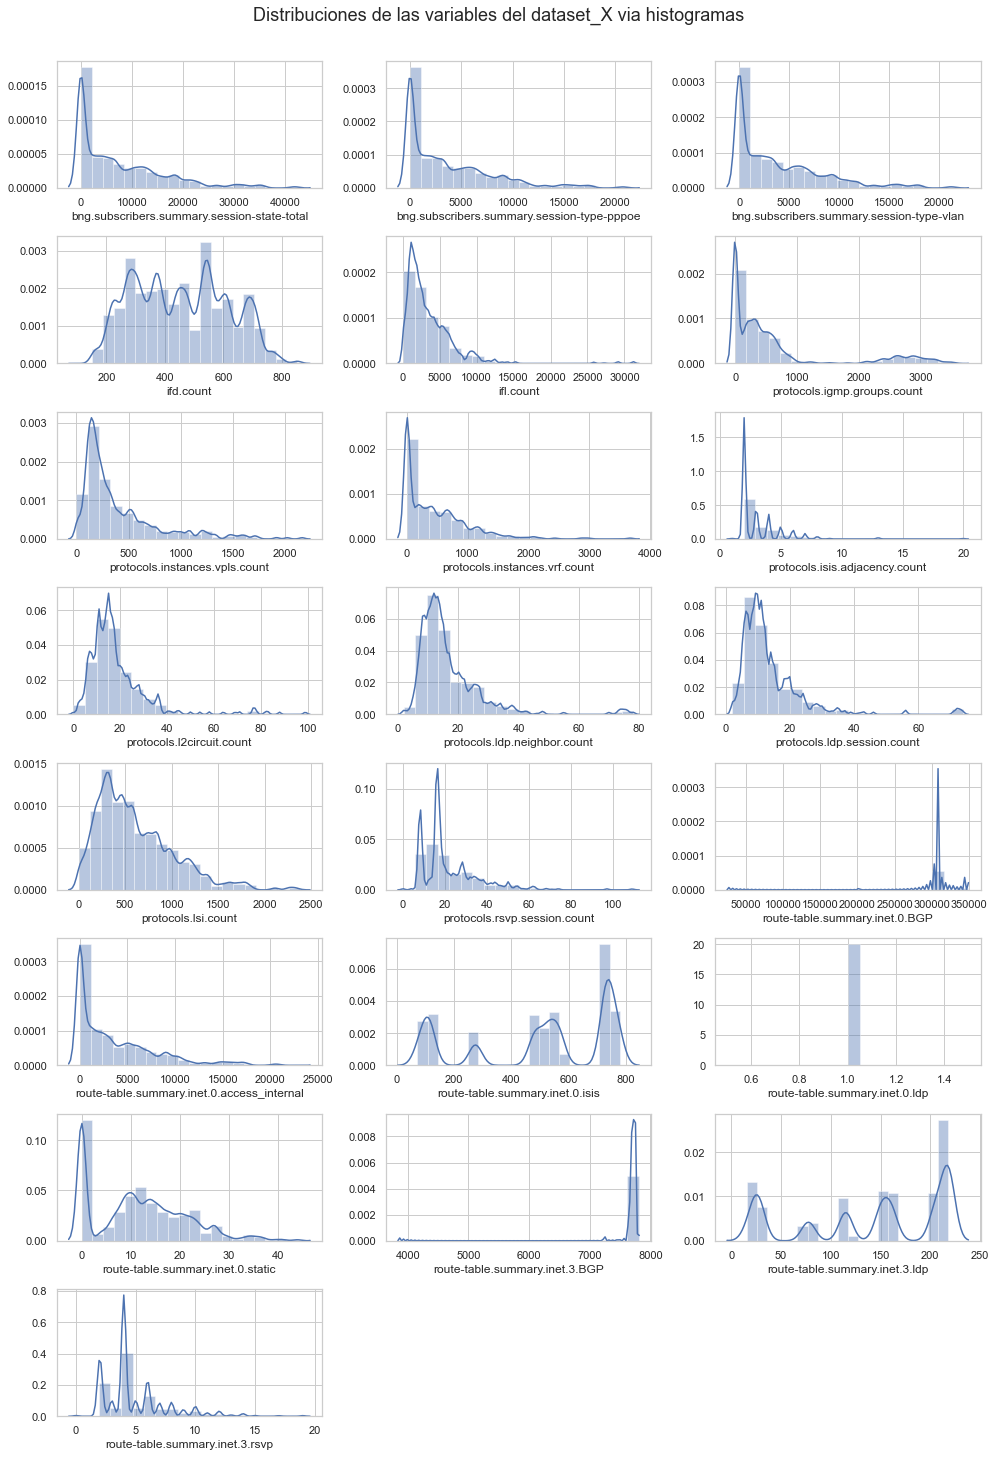

In [30]:
#### Grafico de distribucion de variables predictoras
sns.set(style="whitegrid" , palette="deep")
fig, ax = plt.subplots(figsize = (14, 50))
fig.suptitle('Distribuciones de las variables del dataset_X via histogramas', fontsize=18);   
for i, col in enumerate(dataset_X.columns):
    plt.subplot(20, 3, i+1)
    sns.distplot(dataset_X.iloc[:,i],bins=20)
    plt.axis('on')
fig.tight_layout()
fig.subplots_adjust(top=0.965)

In [31]:
## La mayoria de los KPI aunque tengan rangos amplios de valores, en sus  histogramas 
## presentan sus valores mas frecuentes en los rangos bajos, con una 'skew' muy pronunciada
## y asimetria en la 'campana' hacia los valores mas altos.

### Valores típicos e inusuales<a name="Valores"/>

In [32]:
dataset_X.describe()

kpi,bng.subscribers.summary.session-state-total,bng.subscribers.summary.session-type-pppoe,bng.subscribers.summary.session-type-vlan,ifd.count,ifl.count,protocols.igmp.groups.count,protocols.instances.vpls.count,protocols.instances.vrf.count,protocols.isis.adjacency.count,protocols.l2circuit.count,...,protocols.lsi.count,protocols.rsvp.session.count,route-table.summary.inet.0.BGP,route-table.summary.inet.0.access_internal,route-table.summary.inet.0.isis,route-table.summary.inet.0.ldp,route-table.summary.inet.0.static,route-table.summary.inet.3.BGP,route-table.summary.inet.3.ldp,route-table.summary.inet.3.rsvp
count,194363.000000,194363.000000,194363.000000,194363.000000,194363.000000,194363.000000,194363.000000,194363.000000,194363.000000,194363.000000,...,194363.000000,194363.000000,194363.000000,194363.000000,194363.000000,194363.0,194363.000000,194363.000000,194363.000000,194363.000000
mean,7486.028107,3659.274301,3826.465397,453.828429,3548.131115,642.569699,392.422110,461.328828,3.093222,18.161893,...,605.519780,21.911156,310349.746618,3547.539097,502.400894,1.0,11.680788,7702.046241,140.430334,4.864079
std,8555.563964,4209.069350,4347.628581,158.272465,3382.274720,927.873138,375.042211,526.825576,1.820072,12.839151,...,408.531608,13.649412,16878.988515,4167.950286,246.195154,0.0,9.494249,194.504162,73.014495,2.710907
min,0.000000,0.000000,0.000000,115.000000,77.000000,0.000000,0.000000,3.000000,1.000000,0.000000,...,5.000000,0.000000,24849.000000,0.000000,72.000000,1.0,0.000000,3845.000000,16.000000,0.000000
25%,0.000000,0.000000,0.000000,313.000000,1347.000000,0.000000,147.000000,8.000000,2.000000,11.000000,...,295.000000,16.000000,308049.000000,0.000000,276.000000,1.0,0.000000,7692.000000,78.000000,3.000000
50%,4709.000000,2258.000000,2453.000000,451.000000,2624.000000,310.000000,246.000000,312.000000,2.000000,15.000000,...,513.000000,17.000000,309067.000000,2170.000000,531.000000,1.0,11.000000,7718.000000,153.000000,4.000000
75%,12108.000000,5922.000000,6191.000000,578.000000,4820.000000,637.000000,511.000000,720.000000,4.000000,21.000000,...,839.000000,28.000000,309519.000000,5690.000000,733.000000,1.0,18.000000,7744.000000,218.000000,6.000000
max,42584.000000,21151.000000,21741.000000,852.000000,31285.000000,3647.000000,2164.000000,3670.000000,20.000000,99.000000,...,2376.000000,110.000000,349223.000000,23029.000000,778.000000,1.0,44.000000,7807.000000,218.000000,19.000000


In [33]:
# Se puede confirmar las diferentes escalas entre las caracteristicas.

# A priori seria conveniente aplicar un rescalado pero como el modelo a utilizar mas adelante
# es un Ramdon Forest, pues no es tan necesario.

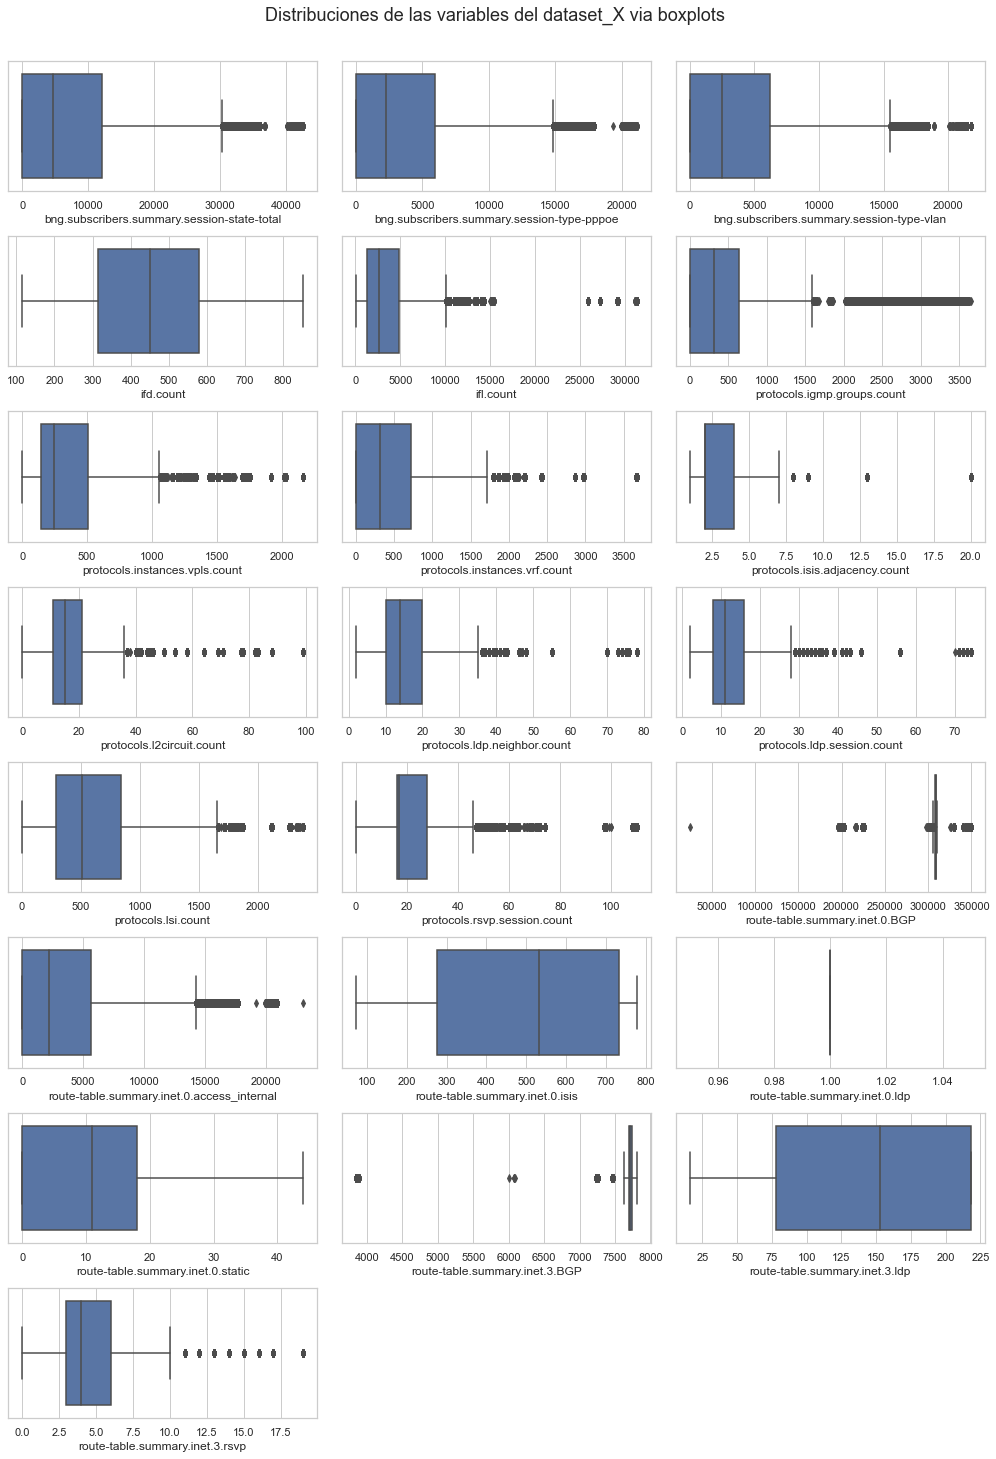

In [34]:
# Otra forma de visualizar la distribucion de los datos e identificar Outliers seria
# utilizando boxplots
sns.set(style="whitegrid" , palette="deep")
fig, ax = plt.subplots(figsize = (14, 50))
fig.suptitle('Distribuciones de las variables del dataset_X via boxplots', fontsize=18);   
for i, col in enumerate(dataset_X.columns):
    plt.subplot(20, 3, i+1)
    sns.boxplot(dataset_X.iloc[:,i])
    plt.axis('on')
plt.tight_layout()
fig.subplots_adjust(top=0.965)

In [35]:
# Para varios KPI si se encuetran o visualizan outliers, no obstante pensamos que se tratan
# de casos esperables donde equipos puedan estar muy cargados de recursos y por lo tanto
# no vemos conveniente eliminarlos por ahora.

### Correlación entre variables <a name="Correlación"/>

In [36]:
# Debido al volumen de variables que se estan manejando procedemos a ver cuales de ellas se
# encuentran correladas y ver la viabilidad de que podamos eliminar alguna de dichas variables.

# A pesar que sabemos que correlacion no implica causalidad, utilizando nuestro conocimiento 
# previo sobre el dataset y corrorando con las herramientas matematicas, cuales variables 
# si se encuentran correlacionadas.

(22.5, -0.5)

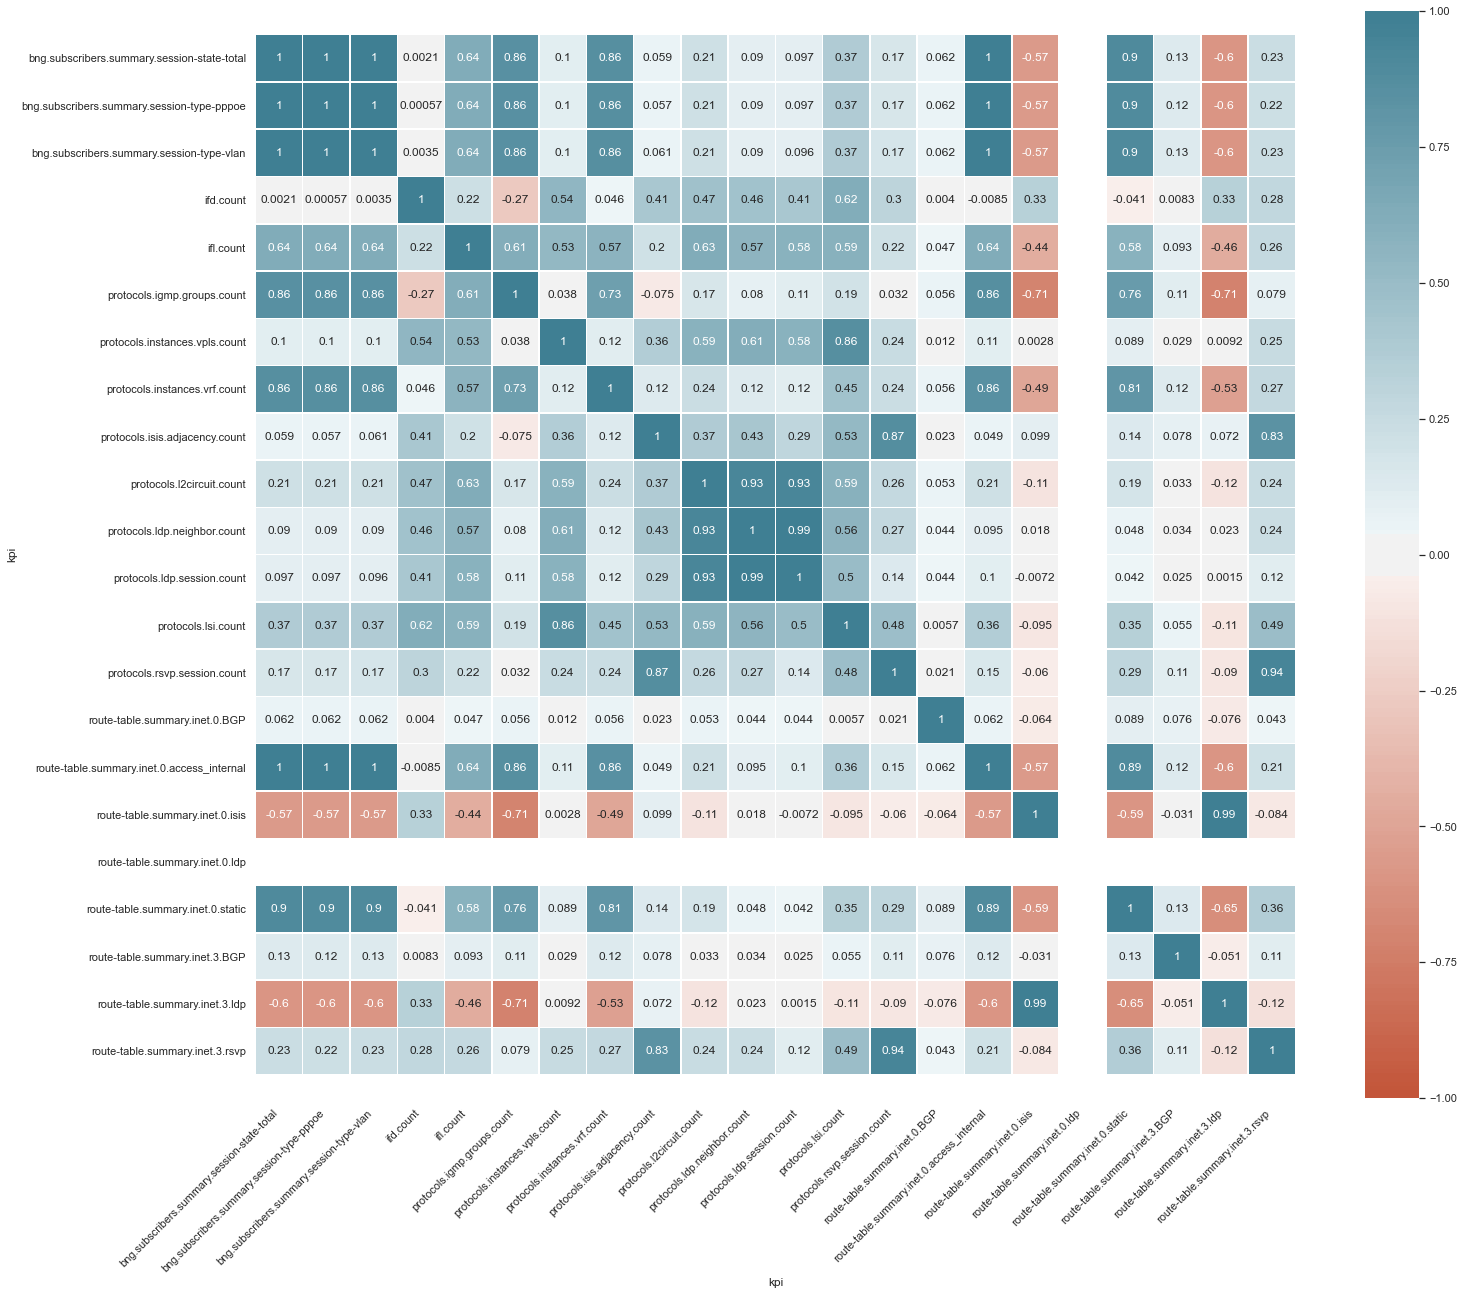

In [37]:
# Correlacion de variables predictoras
plt.figure(figsize=(25,20))
corr = dataset_X.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    linewidths=.5
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [38]:
# Dada esta matriz, procedemos a quedarnos con las variables con mayor correlacion para realizar un análisis mas
# exhaustivo.

# Las variables con mayor correlacion (positiva o negativa) son:

df_corr = dataset_X.corr().stack().abs()
df_corr = df_corr[df_corr.index.get_level_values(0) != df_corr.index.get_level_values(1)]
df_most_correlated = pd.DataFrame(df_corr.sort_values(kind="quicksort",ascending=False))
df_most_correlated.head(20)

0
kpi                                         kpi                                                  
bng.subscribers.summary.session-state-total bng.subscribers.summary.session-type-vlan    0.999844
bng.subscribers.summary.session-type-vlan   bng.subscribers.summary.session-state-total  0.999844
bng.subscribers.summary.session-state-total bng.subscribers.summary.session-type-pppoe   0.999834
bng.subscribers.summary.session-type-pppoe  bng.subscribers.summary.session-state-total  0.999834
                                            bng.subscribers.summary.session-type-vlan    0.999366
bng.subscribers.summary.session-type-vlan   bng.subscribers.summary.session-type-pppoe   0.999366
bng.subscribers.summary.session-type-pppoe  route-table.summary.inet.0.access_internal   0.999232
route-table.summary.inet.0.access_internal  bng.subscribers.summary.session-type-pppoe   0.999232
bng.subscribers.summary.session-state-total route-table.summary.inet.0.access_internal   0.998901
route-table.summary.inet.0.access_internal  bng.subscribers.summary.session-state-total  0.998901
bng.subscribers.summary.session-type-vlan   route-table.summary.inet.0.access_internal   0.998278
route-table.summary.inet.0.access_internal  bng.subscribers.summary.session-type-vlan    0.998278
route-table.summary.inet.3.ldp              route-table.summary.inet.0.isis              0.988682
route-table.summary.inet.0.isis             route-table.summary.inet.3.ldp               0.988682
protocols.ldp.neighbor.count                protocols.ldp.session.count                  0.987575
protocols.ldp.session.count                 protocols.ldp.neighbor.count                 0.987575
route-table.summary.inet.3.rsvp             protocols.rsvp.session.count                 0.943000
protocols.rsvp.session.count                route-table.summary.inet.3.rsvp              0.943000
protocols.l2circuit.count                   protocols.ldp.neighbor.count                 0.933465
protocols.ldp.neighbor.count                protocols.l2circuit.count                    0.933465

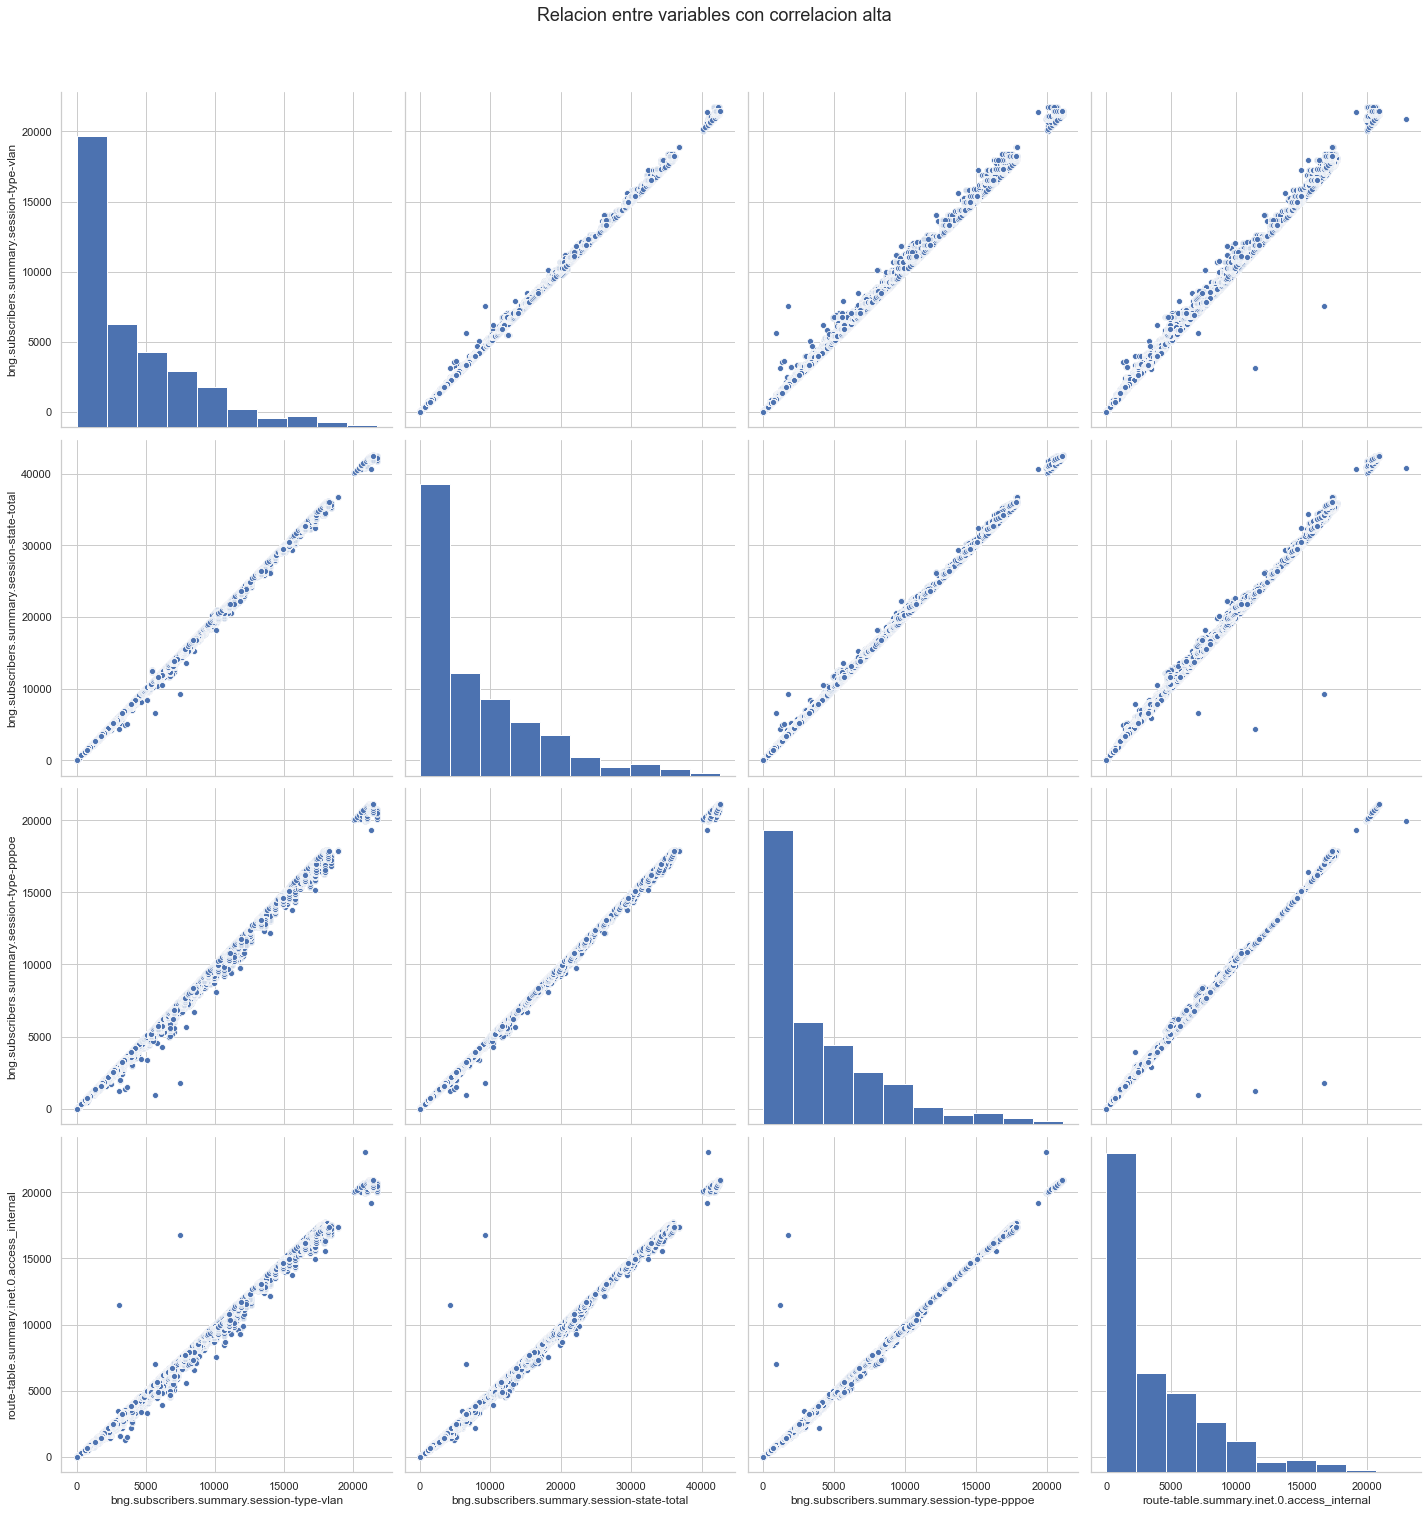

In [39]:
####  Reduccion de variables independientes fuertemente correladas

# Las siguientes variables estan muy correlacionadas entre ellas:
#
#    'bng.subscribers.summary.session-type-vlan',
#    'bng.subscribers.summary.session-state-total',
#    'bng.subscribers.summary.session-type-pppoe',
#    'route-table.summary.inet.0.access_internal'
#

columns_to_review = [
     'bng.subscribers.summary.session-type-vlan',
     'bng.subscribers.summary.session-state-total',
     'bng.subscribers.summary.session-type-pppoe',
     'route-table.summary.inet.0.access_internal',
]
sns.set(style="whitegrid" , palette="deep")
g = sns.pairplot(dataset_X[columns_to_review], kind='scatter', diag_kind='hist', height=5, aspect=1 )
plt.tight_layout()
g.fig.suptitle("Relacion entre variables con correlacion alta", fontsize=18, y=1.05);

In [40]:
# Al ver estas graficas podemos corroborar que estas variables estan altamente correladas entre ellas y podemos
# por lo tanto eliminar todas mes una.

columns_to_drop = [
     'bng.subscribers.summary.session-type-vlan',
     'bng.subscribers.summary.session-state-total',
     'bng.subscribers.summary.session-type-pppoe',
]
dataset_X = dataset_X.drop(columns = columns_to_drop )

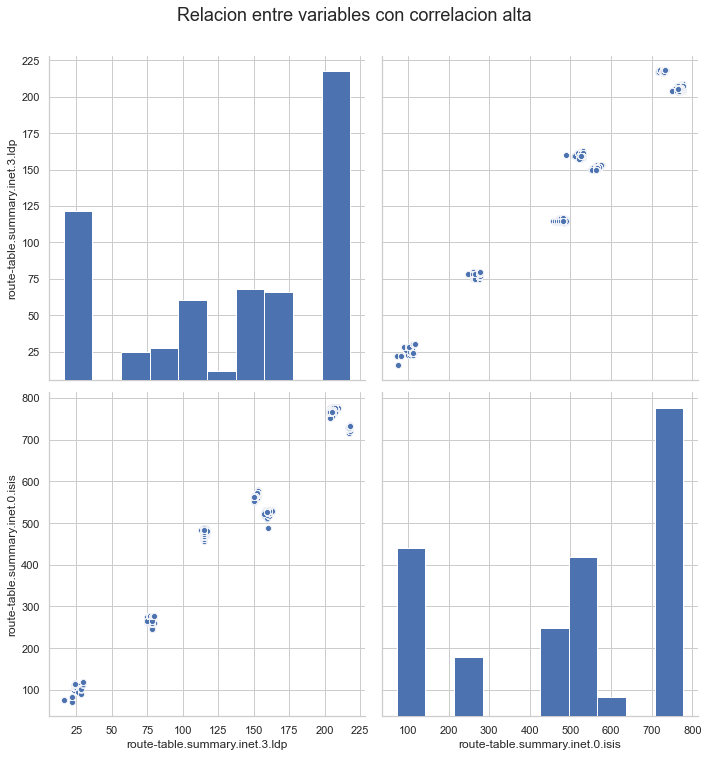

In [41]:
# Las siguientes variables estan muy correlacionadas entre ellas:
#
#    route-table.summary.inet.3.ldp
#    route-table.summary.inet.0.isis
#
columns_to_review = [
    'route-table.summary.inet.3.ldp',
    'route-table.summary.inet.0.isis',
]
sns.set(style="whitegrid" , palette="deep")
g = sns.pairplot(dataset_X[columns_to_review], kind='scatter', diag_kind='hist', height=5, aspect=1 )
plt.tight_layout()
g.fig.suptitle("Relacion entre variables con correlacion alta", fontsize=18, y=1.05);

In [42]:
# Al ver estas graficas podemos corroborar que estas variables estan altamente correladas entre ellas y podemos
# por lo tanto eliminar todas mes una.

columns_to_drop = [
    'route-table.summary.inet.3.ldp',
]
dataset_X = dataset_X.drop(columns = columns_to_drop )

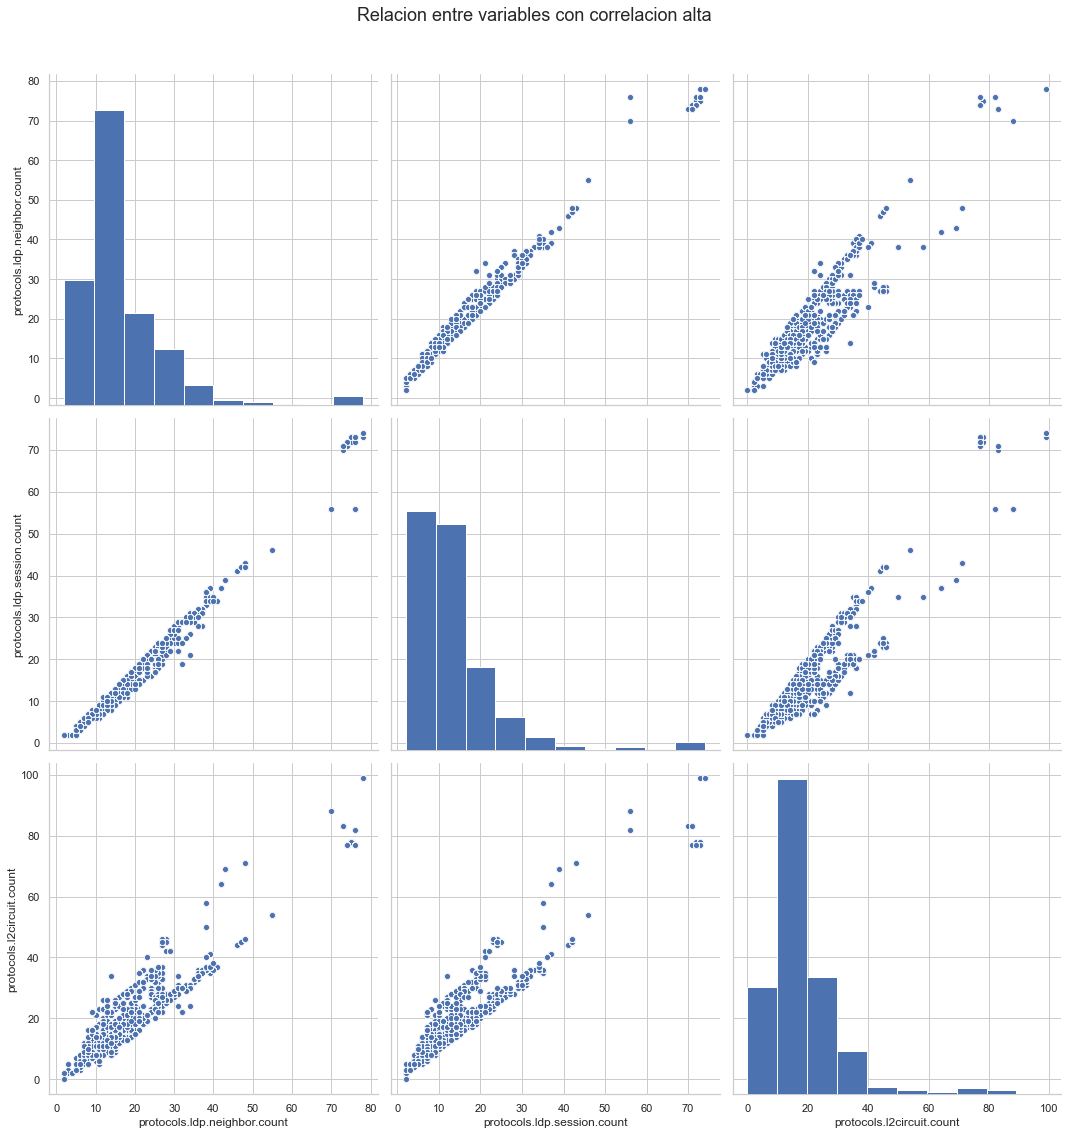

In [43]:
# Las siguientes variables estan muy correlacionadas entre ellas:
#
#    protocols.ldp.neighbor.count
#    protocols.ldp.session.count
#    protocols.l2circuit.count   
#

columns_to_review = [
    'protocols.ldp.neighbor.count',
    'protocols.ldp.session.count',
    'protocols.l2circuit.count'
]
sns.set(style="whitegrid" , palette="deep")
g = sns.pairplot(dataset_X[columns_to_review], kind='scatter', diag_kind='hist', height=5, aspect=1 )
plt.tight_layout()
g.fig.suptitle("Relacion entre variables con correlacion alta", fontsize=18, y=1.05);

In [44]:
# Al ver estas graficas podemos corroborar que estas variables aunque tienen un valor alto 
# de correlacion entre ellas entre protocols.ldp.neighbor.count y protocols.ldp.session.count 
# se observa una relacion mas lineal, por lo que solo procedemos a eliminar una de ellas dos.

columns_to_drop = [
    'protocols.ldp.neighbor.count'
]
dataset_X = dataset_X.drop(columns = columns_to_drop )

In [45]:
dataset_X.shape

(194363, 17)

## Modelo de Regresion <a name="Regresion"/>

In [46]:
# El problema que tratamos de resolver es un problema de regresion donde en base a una serie
# de variables independientes, tratamos de obtener el valor de las variables dependientes 
# (consumos).

# Puesto que en nuestro caso no se trata de relaciones puramente lineales, hemos decido 
# escoger RandomforestRegressor, que entre otras cosas soporta multi-target de manera nativa.

### Creación del conjunto de entrenamiento y test <a name="Conjunto"/>

In [47]:
# Para mejorar la validación del modelo hemos optado por una aproximacion distinta, 
# donde creamos un dataset de entrenamiento y 2 datasets de validacion

# Cada dataset de validacion intenta probar el modelo ante situaciones distintas.

# 1.- El primer dataset intenta validar el modelo ante NUEVAS muestras tomadas de los
#     MISMOS devices con los que fue entrenado el modelo.
# 2.- El segundo dataset tendra todas las muestras recopiladas de OTRO conjunto de equipos
#     los cuales el modelo desconoce.

# El trasfondo por el cual hemos optado por esta aproximación es evitar de alguna manera,
# que exista un cierto grado de 'data leakage' entre el conjunto de pruebas y el de 
# entrenamiento. 

# Procedemos a obtener los datastes

# Se define un ratio entre los grupos de devices de prueba y entrenamiento
ratio_test_train = 4
# Obtenemos la lista de todos los devices
devices = dataset_X.index.unique().tolist()
# Seleccionamos de forma aleatoria los dispositivos para entrenamiento en base al ratio
devices_train = random.sample(devices, int(len(devices)//ratio_test_train))
# El restante de los devices formaran parte del grupo de validacion
devices_test = list(set(devices) - set(devices_train))


# Del grupo de dispositivos para entrenamiento, creamos de forma aleatoria el dataset
# de entrenamiento y el primer dataset de pruebas
X_train, X_test, y_train, y_test = train_test_split(dataset_X[dataset_X.index.isin(devices_train)], 
                                                    dataset_y[dataset_y.index.isin(devices_train)], 
                                                    test_size=.3, 
                                                    random_state=1976)

# A continuacion definimos el segundo dataset de pruebas
X_test2 = dataset_X[dataset_X.index.isin(devices_test)]
y_test2 = dataset_y[dataset_y.index.isin(devices_test)]

In [48]:
# Revisamos las dimensiones de los dataset
print('Las dimensiones de los dataset son:')
print('- Dataset de entrenamiento es X_train : {0} y y_train :{1}'.format(X_train.shape,y_train.shape))
print('- Primer dataset de validacion es X_test : {0} y y_test : {1}'.format(X_test.shape,y_test.shape))
print('- Segundo dataset de validacion es X_test2 : {0} y y_test2 : {1}'.format(X_test2.shape,y_test2.shape))

Las dimensiones de los dataset son:
- Dataset de entrenamiento es X_train : (34171, 17) y y_train :(34171, 15)
- Primer dataset de validacion es X_test : (14645, 17) y y_test : (14645, 15)
- Segundo dataset de validacion es X_test2 : (145547, 17) y y_test2 : (145547, 15)


### Entrenamiento del modelo <a name="Entrenamiento"/>

In [49]:
# La estrategia realizada para realizar el entrenamiento se divide en 3 partes:

# 1.- Entrenamiento basico del modelo con sus parametros por defecto.
# 2.- Hiperparametrizacion del modelo, incluyendo crosvalidacion para encontrar 
#     un mejor resultado.
# 3.- Evaluar los resultados del modelo por defecto y el 'mejor hyperparametrizado'

#### Modelo básico <a name="básico"/>

In [50]:
# Inicializamos el modelo y revisamos su parametrización por defecto

rfr_basico = RandomForestRegressor(random_state = 1976)
rfr_basico

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1976, verbose=0, warm_start=False)

In [51]:
# Entrenamos el modelo con el dataset de entrenamiento
rfr_basico.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1976, verbose=0, warm_start=False)

In [52]:
# Evaluamos el resultado del modelo con el dataset de entrenamiento
rfr_basic_score_train = rfr_basico.score(X_train, y_train)
rfr_basic_score_train

0.9999964199106874

In [53]:
# Evaluamos el resultado del modelo con el primer dataset pruebas 
rfr_basic_score_test1 = rfr_basico.score(X_test, y_test)
rfr_basic_score_test1

0.9998768371778409

In [54]:
# Evaluamos el resultado del modelo con el segundo dataset pruebas 
rfr_basic_score_test2 = rfr_basico.score(X_test2, y_test2)
rfr_basic_score_test2

0.9289259155611872

#### Hiperparametrizacion y crosvalidacion del modelo <a name="Hiperparametrizacion"/>

In [55]:
# Creamos nuestra matriz con algunos de parametros del modelo

# numero de arboles
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Numero de features a considerar en cada split
max_features = ['auto', 'sqrt']
# Numero maximo de niveles 
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo numero de muestras requeridas para splitear un nodo
min_samples_split = [2, 5, 10]
# Minimo numero de muestras requeridas en cada hoja
min_samples_leaf = [1, 2, 4]
# Método de selección de muestras para el entrenamiento de cada árbol
bootstrap = [True, False]
# Diferentes metodos de scoring
scoring = {'R2': 'r2', 'NMAE':'neg_mean_absolute_error','NMAE2':'neg_mean_squared_error'}
# Creacion del random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap }
random_grid

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [56]:
# Usamos el RandomizedSearchCV con la matriz de parametros anterior, 
# un maximo iteraciones y cross validacion de 3

rfr = RandomForestRegressor(random_state = 42)
rfr_RandomizedSearchCV = RandomizedSearchCV(estimator = rfr, 
                                           param_distributions = random_grid, 
                                           scoring=scoring,
                                           n_iter = 15, # Dejamos 15 por acotar
                                           cv = 3, 
                                           verbose=2, 
                                           random_state=42, 
                                           n_jobs = -1,
                                           refit='NMAE',
                                           return_train_score=True)
rfr_RandomizedSearchCV.fit(X_train, y_train)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 37.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [57]:
# Los parametros que corresponden al modelo con mejor resultado fueron
rfr_RandomizedSearchCV.best_params_

{'n_estimators': 733,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [58]:
rfr_best = rfr_RandomizedSearchCV.best_estimator_

In [59]:
# Evaluamos el resultado del modelo con el dataset de entrenamiento
rfr_best_score_train = rfr_best.score(X_train, y_train)
rfr_best_score_train

0.9999998000430687

In [60]:
# Evaluamos el resultado del modelo con el primer dataset pruebas 
rfr_best_score_test1 = rfr_best.score(X_test, y_test)
rfr_best_score_test1

0.9999743054380416

In [61]:
# Evaluamos el resultado del modelo con el segundo dataset pruebas 
rfr_best_score_test2 = rfr_best.score(X_test2, y_test2)
rfr_best_score_test2

0.9670254762934475

#### Evaluacion de los modelos hiperparametrizados <a name="Evaluacion"/>

In [62]:
# Matriz de resultados de las X iteraciones de RandomGridSearch
df_gridsearch = pd.DataFrame(rfr_RandomizedSearchCV.cv_results_)
df_gridsearch

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,...,split1_test_NMAE2,split2_test_NMAE2,mean_test_NMAE2,std_test_NMAE2,rank_test_NMAE2,split0_train_NMAE2,split1_train_NMAE2,split2_train_NMAE2,mean_train_NMAE2,std_train_NMAE2
0,10.807807,0.007756,0.381015,0.000334,100,10,2,sqrt,50,True,...,-4.596595e+06,-2.052418e+06,-3.294232e+06,1.039538e+06,11,-1.635509e+06,-1.369983e+06,-2.001344e+06,-1.668945e+06,258834.055500
1,84.940383,0.216932,3.223048,0.075124,522,10,4,sqrt,90,False,...,-4.551013e+06,-2.050660e+06,-3.270702e+06,1.021654e+06,10,-1.569265e+06,-1.290277e+06,-2.043359e+06,-1.634300e+06,310864.881890
2,296.641116,0.995682,11.672595,0.931316,522,2,2,auto,60,False,...,-4.115512e+06,-1.618865e+06,-3.297288e+06,1.186948e+06,13,-1.241141e+06,-8.550243e+05,-1.388181e+06,-1.161449e+06,224836.570341
3,178.690565,8.213033,19.767639,2.886386,1366,5,1,sqrt,30,True,...,-3.874963e+06,-1.468698e+06,-2.677214e+06,9.823831e+05,4,-5.209776e+05,-4.364421e+05,-6.459034e+05,-5.344410e+05,86040.542218
4,536.324693,3.315206,10.956470,1.900191,944,10,1,auto,80,False,...,-3.765179e+06,-1.654813e+06,-2.876533e+06,8.931648e+05,6,-1.524864e+05,-1.732666e+05,-1.761734e+05,-1.673088e+05,10547.989284
5,62.760094,1.119373,1.736157,0.269412,311,10,1,sqrt,60,False,...,-3.693213e+06,-1.466578e+06,-2.641002e+06,9.131187e+05,2,-2.028364e+05,-1.400352e+05,-1.979746e+05,-1.802821e+05,28527.973776
6,1262.820019,5.800204,88.544222,3.335675,2000,2,2,auto,50,False,...,-4.116520e+06,-1.616537e+06,-3.296172e+06,1.187788e+06,12,-1.241141e+06,-8.550243e+05,-1.388181e+06,-1.161449e+06,224836.570341
7,9.235351,0.099819,0.226482,0.001774,100,5,2,sqrt,10,True,...,-1.752208e+07,-1.476369e+07,-1.645698e+07,1.210551e+06,15,-1.588970e+07,-1.543106e+07,-1.497530e+07,-1.543202e+07,373300.267523
8,406.336389,2.825754,9.730259,1.501684,1155,2,4,auto,100,True,...,-4.092548e+06,-1.593671e+06,-3.031041e+06,1.054215e+06,8,-1.736938e+06,-1.471791e+06,-2.264556e+06,-1.824428e+06,329504.426649
9,825.003743,14.792359,93.746423,47.833366,2000,5,2,auto,50,True,...,-3.923115e+06,-1.359933e+06,-2.864002e+06,1.092692e+06,5,-1.196814e+06,-9.133114e+05,-1.484711e+06,-1.198279e+06,233275.272711


In [63]:
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()

In [64]:
max_scores_R2 = max_scores.unstack()[['mean_test_R2','mean_train_R2']]

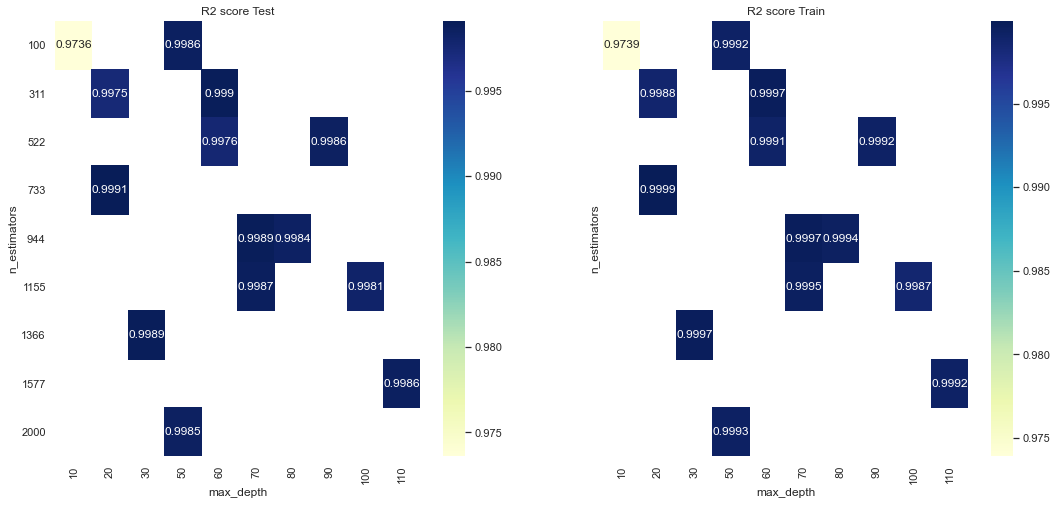

In [65]:
# HeatMap para la metrica R2 de test/train en relacion a dos hiperparametros importantes
f,(ax1,ax2) = plt.subplots(1,2, 
            gridspec_kw={'width_ratios':[1.5,1.5]},figsize=(18,8))

ax1.get_shared_y_axes().join(ax1,ax2)
ax1.title.set_text('R2 score Test')
ax2.title.set_text('R2 score Train')
g1 = sns.heatmap(max_scores_R2.mean_test_R2,cmap="YlGnBu",cbar=True,ax=ax1,annot=True,fmt='.4g')

g1.set_ylabel('n_estimators')
g1.set_xlabel('max_depth')
g2 = sns.heatmap(max_scores_R2.mean_train_R2,cmap="YlGnBu",cbar=True,ax=ax2,annot=True,fmt='.4g')
g2.set_ylabel('n_estimators')
g2.set_xlabel('max_depth')
g2.set_yticks([])

for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top )
plt.show()



In [66]:
max_scores_NMAE = max_scores.unstack()[['mean_test_NMAE','mean_train_NMAE']]

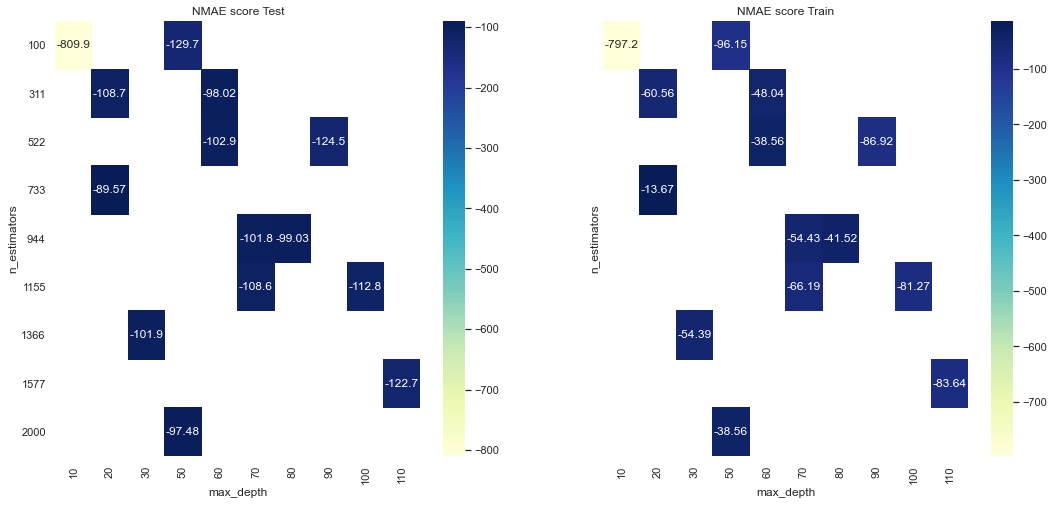

In [67]:
# HeatMap para la metrica NMAE de test/train en relacion a dos hiperparametros importantes

f,(ax1,ax2) = plt.subplots(1,2, 
            gridspec_kw={'width_ratios':[1.5,1.5]},figsize=(18,8))

ax1.get_shared_y_axes().join(ax1,ax2)
ax1.title.set_text('NMAE score Test')
ax2.title.set_text('NMAE score Train')
g1 = sns.heatmap(max_scores_NMAE.mean_test_NMAE,cmap="YlGnBu",cbar=True,ax=ax1,annot=True,fmt='.4g')
g1.set_ylabel('n_estimators')
g1.set_xlabel('max_depth')
g2 = sns.heatmap(max_scores_NMAE.mean_train_NMAE,cmap="YlGnBu",cbar=True,ax=ax2,annot=True,fmt='.4g')
g2.set_ylabel('n_estimators')
g2.set_xlabel('max_depth')
g2.set_yticks([])

for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top )
plt.show()

In [68]:
max_scores_NMAE2 = max_scores.unstack()[['mean_test_NMAE2','mean_train_NMAE2']]

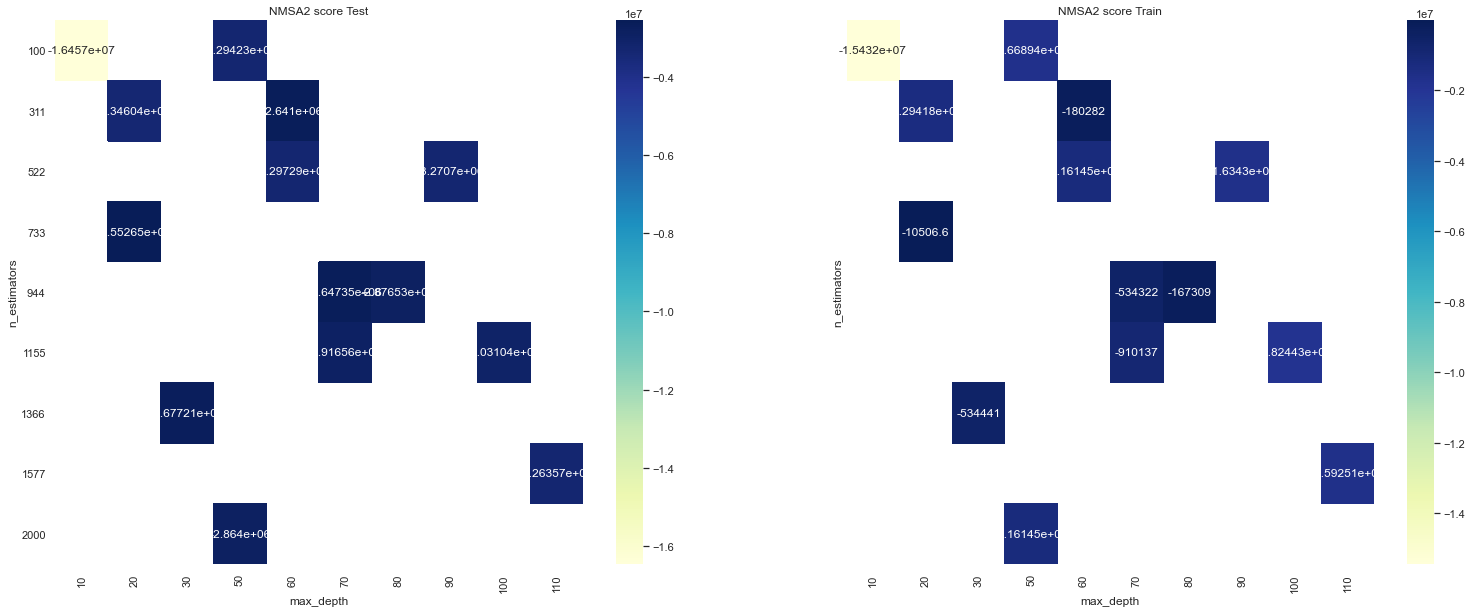

In [69]:
# HeatMap para la metrica NMSE2 de test/train en relacion a dos hiperparametros importantes

f,(ax1,ax2) = plt.subplots(1,2, 
            gridspec_kw={'width_ratios':[1.5,1.5]},figsize=(26,10))

ax1.get_shared_y_axes().join(ax1,ax2)
ax1.title.set_text('NMSA2 score Test')
ax2.title.set_text('NMSA2 score Train')
g1 = sns.heatmap(max_scores_NMAE2.mean_test_NMAE2,cmap="YlGnBu",cbar=True,ax=ax1,annot=True,fmt='.6g')
g1.set_ylabel('n_estimators')
g1.set_xlabel('max_depth')
g2 = sns.heatmap(max_scores_NMAE2.mean_train_NMAE2,cmap="YlGnBu",cbar=True,ax=ax2,annot=True,fmt='.6g')
g2.set_ylabel('n_estimators')
g2.set_xlabel('max_depth')
g2.set_yticks([])

for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top )
plt.show()

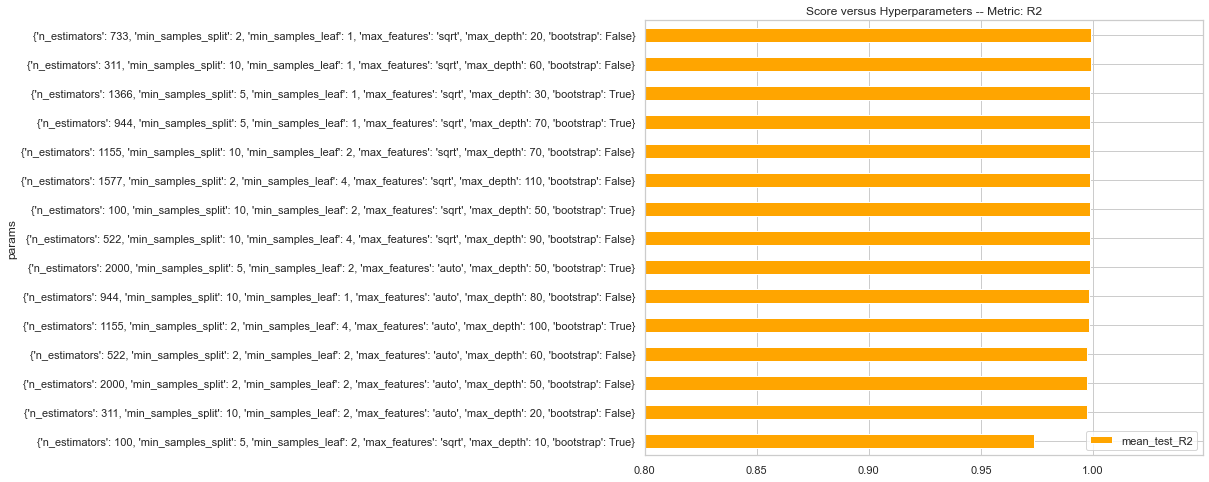

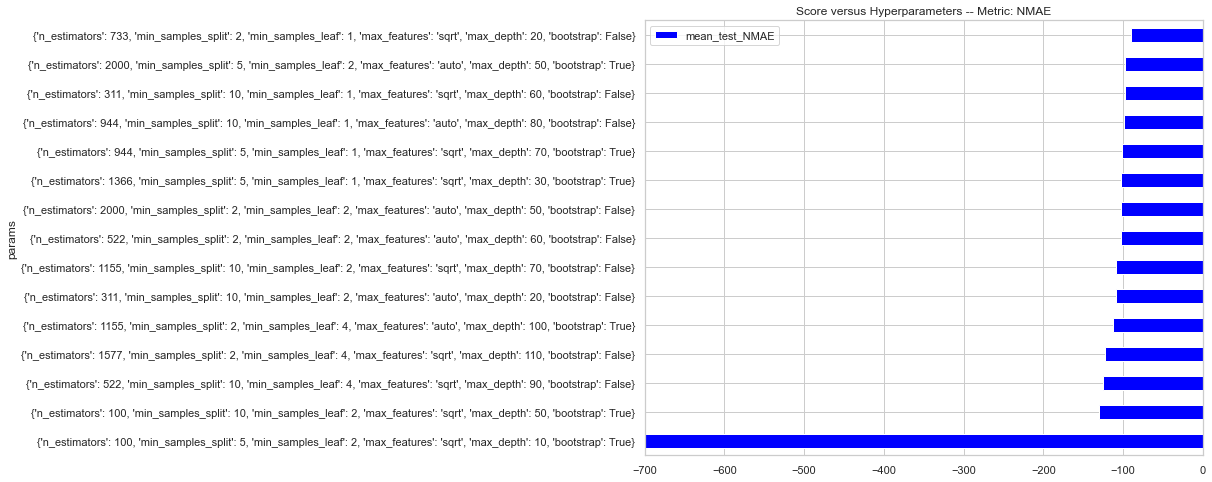

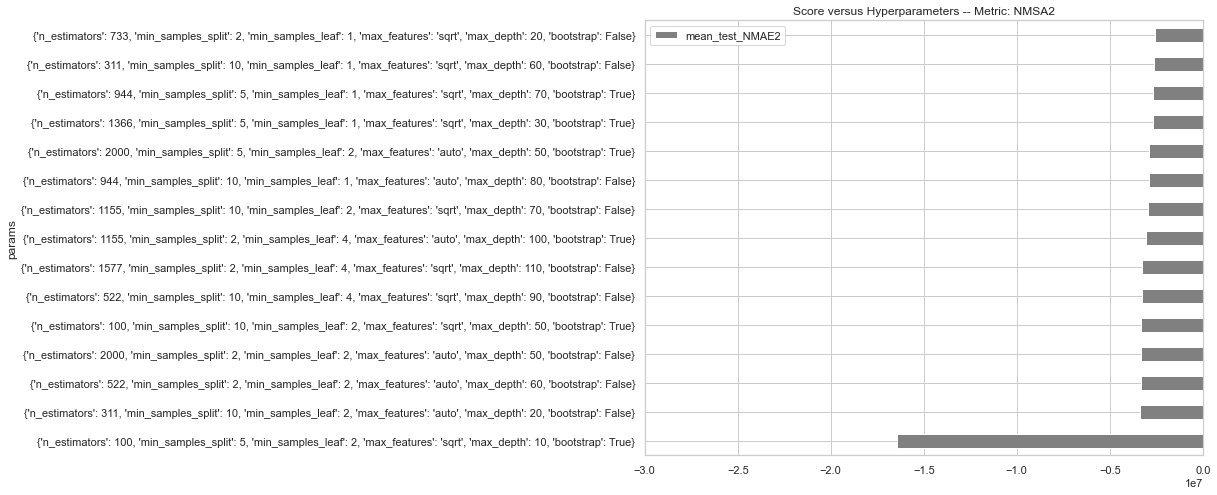

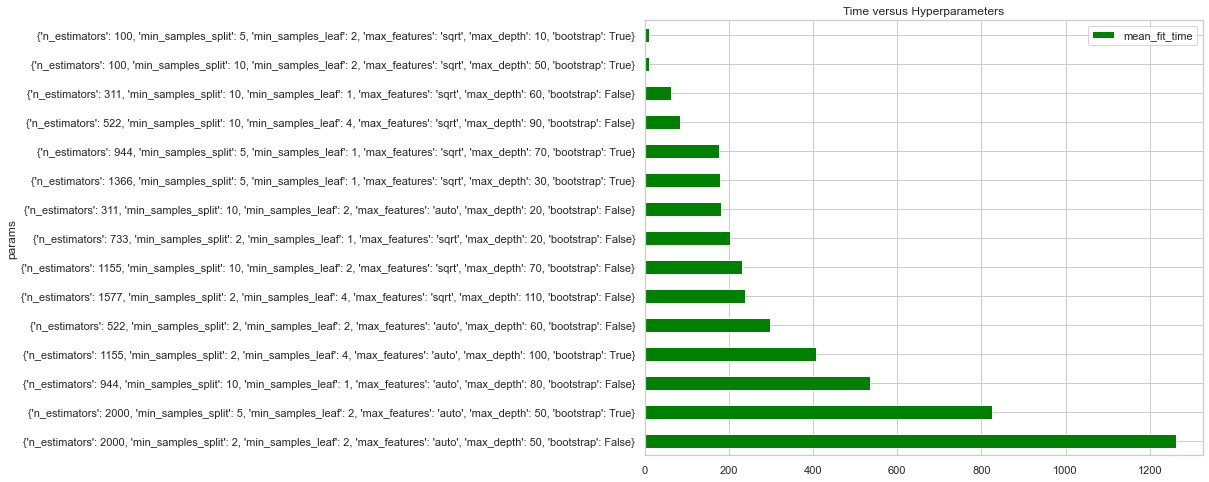

In [70]:
# Grafica para ver  los diferentes scores con respecto a todos los hiperparametros y
# el tiempo de entrenamiento respecto a los mismos

# Parametros de scoring seleccionados

# neg_mean_absolute_error : La función mean_absolute_error calcula el error medio absoluto,
#                           una métrica de riesgo que corresponde al valor esperado de la pérdida del error absoluto.
# neg_mean_squared_error :  La función mean_squared_error calcula el error cuadrático medio, 
#                           una métrica de riesgo que corresponde al valor esperado del error o pérdida cuadráticos.
# R2 : Representa la proporción de varianza (de y) que ha sido explicada por las variables independientes del modelo. 
#      Proporciona una indicación de la bondad del ajuste y, por lo tanto, una medida de lo bien que es probable que las muestras no vistas sean predichas por el modelo,
#      a través de la proporción de la varianza explicada

df_gridsearch.loc[:,'params'] = df_gridsearch.loc[:,'params'].astype(str)
(
  df_gridsearch.sort_values('rank_test_R2',ascending=False)
    .loc[:,['params','mean_test_R2']]
    .plot.barh(x='params',xlim=(0.8),figsize=(10,8),title="Score versus Hyperparameters -- Metric: R2",color='orange')
)
(
  df_gridsearch.sort_values('rank_test_NMAE',ascending=False)
    .loc[:,['params','mean_test_NMAE']]
    .plot.barh(x='params',xlim=(-700.0),figsize=(10,8),title="Score versus Hyperparameters -- Metric: NMAE",color='blue')
)
(
  df_gridsearch.sort_values('rank_test_NMAE2',ascending=False)
    .loc[:,['params','mean_test_NMAE2']]
    .plot.barh(x='params',xlim=(-30000000.0),figsize=(10,8),title="Score versus Hyperparameters -- Metric: NMSA2",color='grey')
)
(
  df_gridsearch.sort_values('mean_fit_time',ascending=False)
    .loc[:,['params','mean_fit_time']]
    .plot.barh(x='params',xlim=(0.0),figsize=(10,8),title="Time versus Hyperparameters",color='green')
)

#### Comparación entre mejor modelo hiperparametrizado y modelo por defecto <a name="Comparación"/>

###### Comparación del error

In [71]:
# Una vez seleccionado el mejor modelo hiperarametrizado, procedemos a evaluarlo con
# respecto al modelo con los parametros por defecto.

# Utilizando una funcion wrapper mediremos el error de cada modelo, para cada una
# de las variables objetivo y tomaremos conclusiones a partir de alli.

In [72]:
# Funcion wraper que evalua el error como la diferencia entre el valor predicho y 
# el valor real
def evaluate(model, X, Y):
    predictions = model.predict(X)
    errors = abs(predictions - Y)
    return np.mean(errors)

In [73]:
# Modelo Base
base_error = evaluate(rfr_basico, X_test2, y_test2)
# Modelo Hiperparametrizado
rfr_best = rfr_RandomizedSearchCV.best_estimator_
best_error = evaluate(rfr_best, X_test2, y_test2)

In [74]:
model_errors = pd.concat((base_error.rename('Error_base'),best_error.rename('Error_best')), 
                         axis=1)
model_errors['ratio']=model_errors['Error_best']/model_errors['Error_base']
model_errors

,Error_base,Error_best,ratio
kpi,,,
Composite.nh,1142.402208,895.748886,0.784092
EDMEM.percent,0.900390,0.599125,0.665405
IDMEM.percent,1.338841,1.041843,0.778168
Indirect.nh,665.841256,572.407160,0.859675
Label.nh,4766.786359,3979.521857,0.834844
Unicast.nh,1187.268760,803.856596,0.677064
Unilist.nh,907.425643,751.295655,0.827942
fpc.slot0.free-filter-memory-rsmon-percent,0.569220,0.376035,0.660613
fpc.slot0.free-heap-memory-rsmon-percent,0.875776,0.566358,0.646692


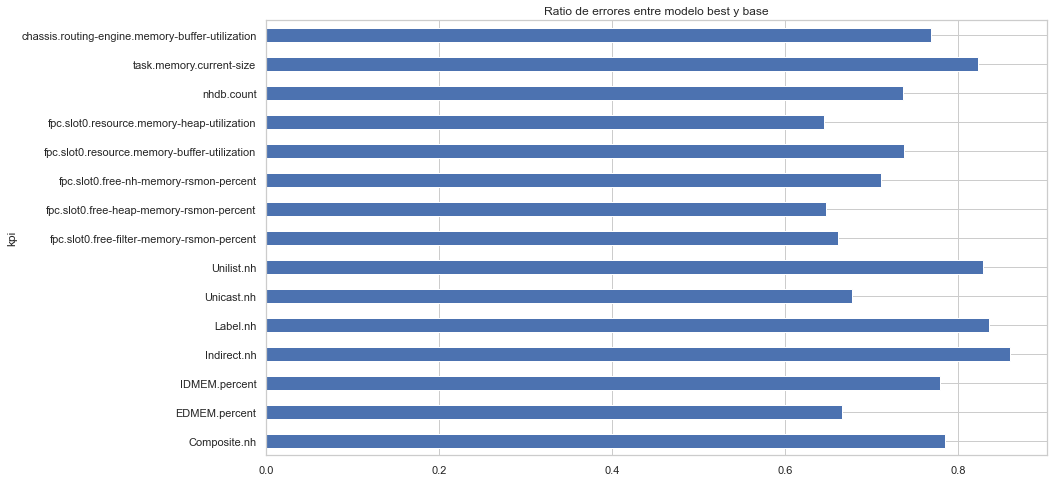

In [75]:
model_errors['ratio'].plot(kind='barh',title='Ratio de errores entre modelo best y base',figsize=(14,8));

In [76]:
# En la grafica se puede observar todos aquellas variables objetivo donde si el ratio es
# mayor a 1, significa que el modelo hiperparametrizado tiene un error mayor, y en caso
# contrario el ratio seria menor a 1.

In [77]:
# Sumamos el total de errores de ambos modelos (Base y Mejor hiperparametrizado)
print("Suma total de errores modelo hiperparametrizado: " , model_errors['Error_best'].sum())
print("Suma total de errores modelo Base: ", model_errors['Error_base'].sum())

Suma total de errores modelo hiperparametrizado:  136288.0310006865
Suma total de errores modelo Base:  166672.8223311349


##### Comparación del score

In [78]:
# Creamos una tabla para resumir los valores obtenidos en ambos modelos
dict_var = {
            'score_train':[rfr_basic_score_train,rfr_best_score_train],
            'score_test1':[rfr_basic_score_test1,rfr_best_score_test1],
            'score_test2':[rfr_basic_score_test2,rfr_best_score_test2],
            'Sum_Error':[model_errors['Error_base'].sum(),model_errors['Error_best'].sum()]
            }
            
df_eval = pd.DataFrame(dict_var,index=['Model Base', 'Model Param']) 
df_eval

,score_train,score_test1,score_test2,Sum_Error
Model Base,0.999996,0.999877,0.928926,166672.822331
Model Param,1.000000,0.999974,0.967025,136288.031001


##### Analisis de la importancia de las variables

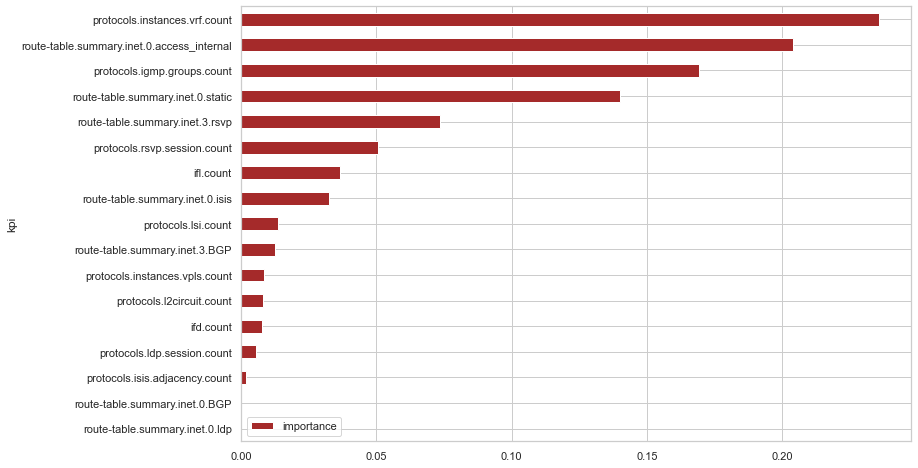

In [79]:
# Sacamos del modelo hiperparametrizado las variables mas relevantes, y las graficamos
# en orden de mayor a menor.
feature_importances = pd.DataFrame(rfr_best.feature_importances_,
                                    index = dataset_X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.sort_values(by='importance',ascending=True).plot(kind='barh',figsize=(12,8),color='brown')

In [80]:
# Nos guardamos la lista con las features mas relevantas para un futuro analisis
top_features = feature_importances.index[0:7].tolist()
top_features

['protocols.instances.vrf.count',
 'route-table.summary.inet.0.access_internal',
 'protocols.igmp.groups.count',
 'route-table.summary.inet.0.static',
 'route-table.summary.inet.3.rsvp',
 'protocols.rsvp.session.count',
 'ifl.count']

## Agrupaciones  <a name="Agrupaciones"/>

In [81]:
# El objetivo es poder clasificar los equipos en base a criterios de carga y crear grupos del tipo:
#   - Carga alta
#   - Carga media-alta
#   - Carga media
#   - Cartga baja

### Creacion de una muestra representativa para agrupar <a name="muestra"/>

In [82]:
# Creamos una muestra de todo el dataset, para generar el dendograma y determinar cuantos grupos se pudiesen generar.
# Para mejorar la calidad del dataset de muestras, forzamos incluir al menos 3 muestras aleatorias por cada device

df_sample = dataset_X.groupby('device', group_keys=False).apply(pd.DataFrame.sample, n=3)

### Creación del dendograma  <a name="dendograma"/>

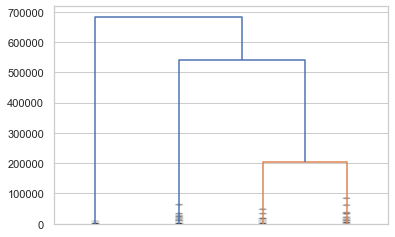

In [83]:
# Creamos el Dendograma para establecer la linea de corte e identificar en cuantos grupos se pueden aglomerar
# el dataset

dendrogram = sch.dendrogram(sch.linkage(df_sample, method='ward'), no_labels=True,p=4,truncate_mode='lastp',show_contracted=True)

### Visualización de las agrupaciones <a name="Visualización"/>

In [84]:
# Tratamos de visualizar la distribucion de los devices en cada grupo

In [85]:
# creamos los clusters
n_clusters = 4
hc = AgglomerativeClustering(n_clusters=n_clusters, affinity = 'euclidean', linkage = 'ward')
# salvamos los clusters para graficarlos
y_hc = hc.fit_predict(df_sample)
df_sample['y_hc'] = y_hc

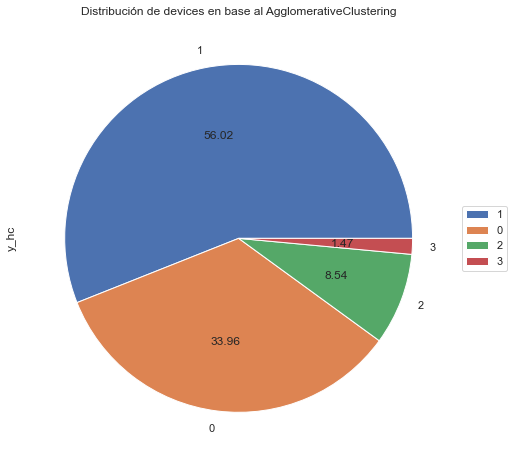

In [86]:
df_sample['y_hc'].value_counts(normalize=True).plot(kind='pie',
                                               subplots = False,
                                               title='Distribución de devices en base al AgglomerativeClustering',
                                               legend = True,
                                               autopct='%.2f',
                                               figsize=(8, 8)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

### Profiling <a name="Profiling"/>

In [87]:
# Para realizar el profiling de los 4 grupos procedemos a realizar un pairplot con las variables mas relevantes

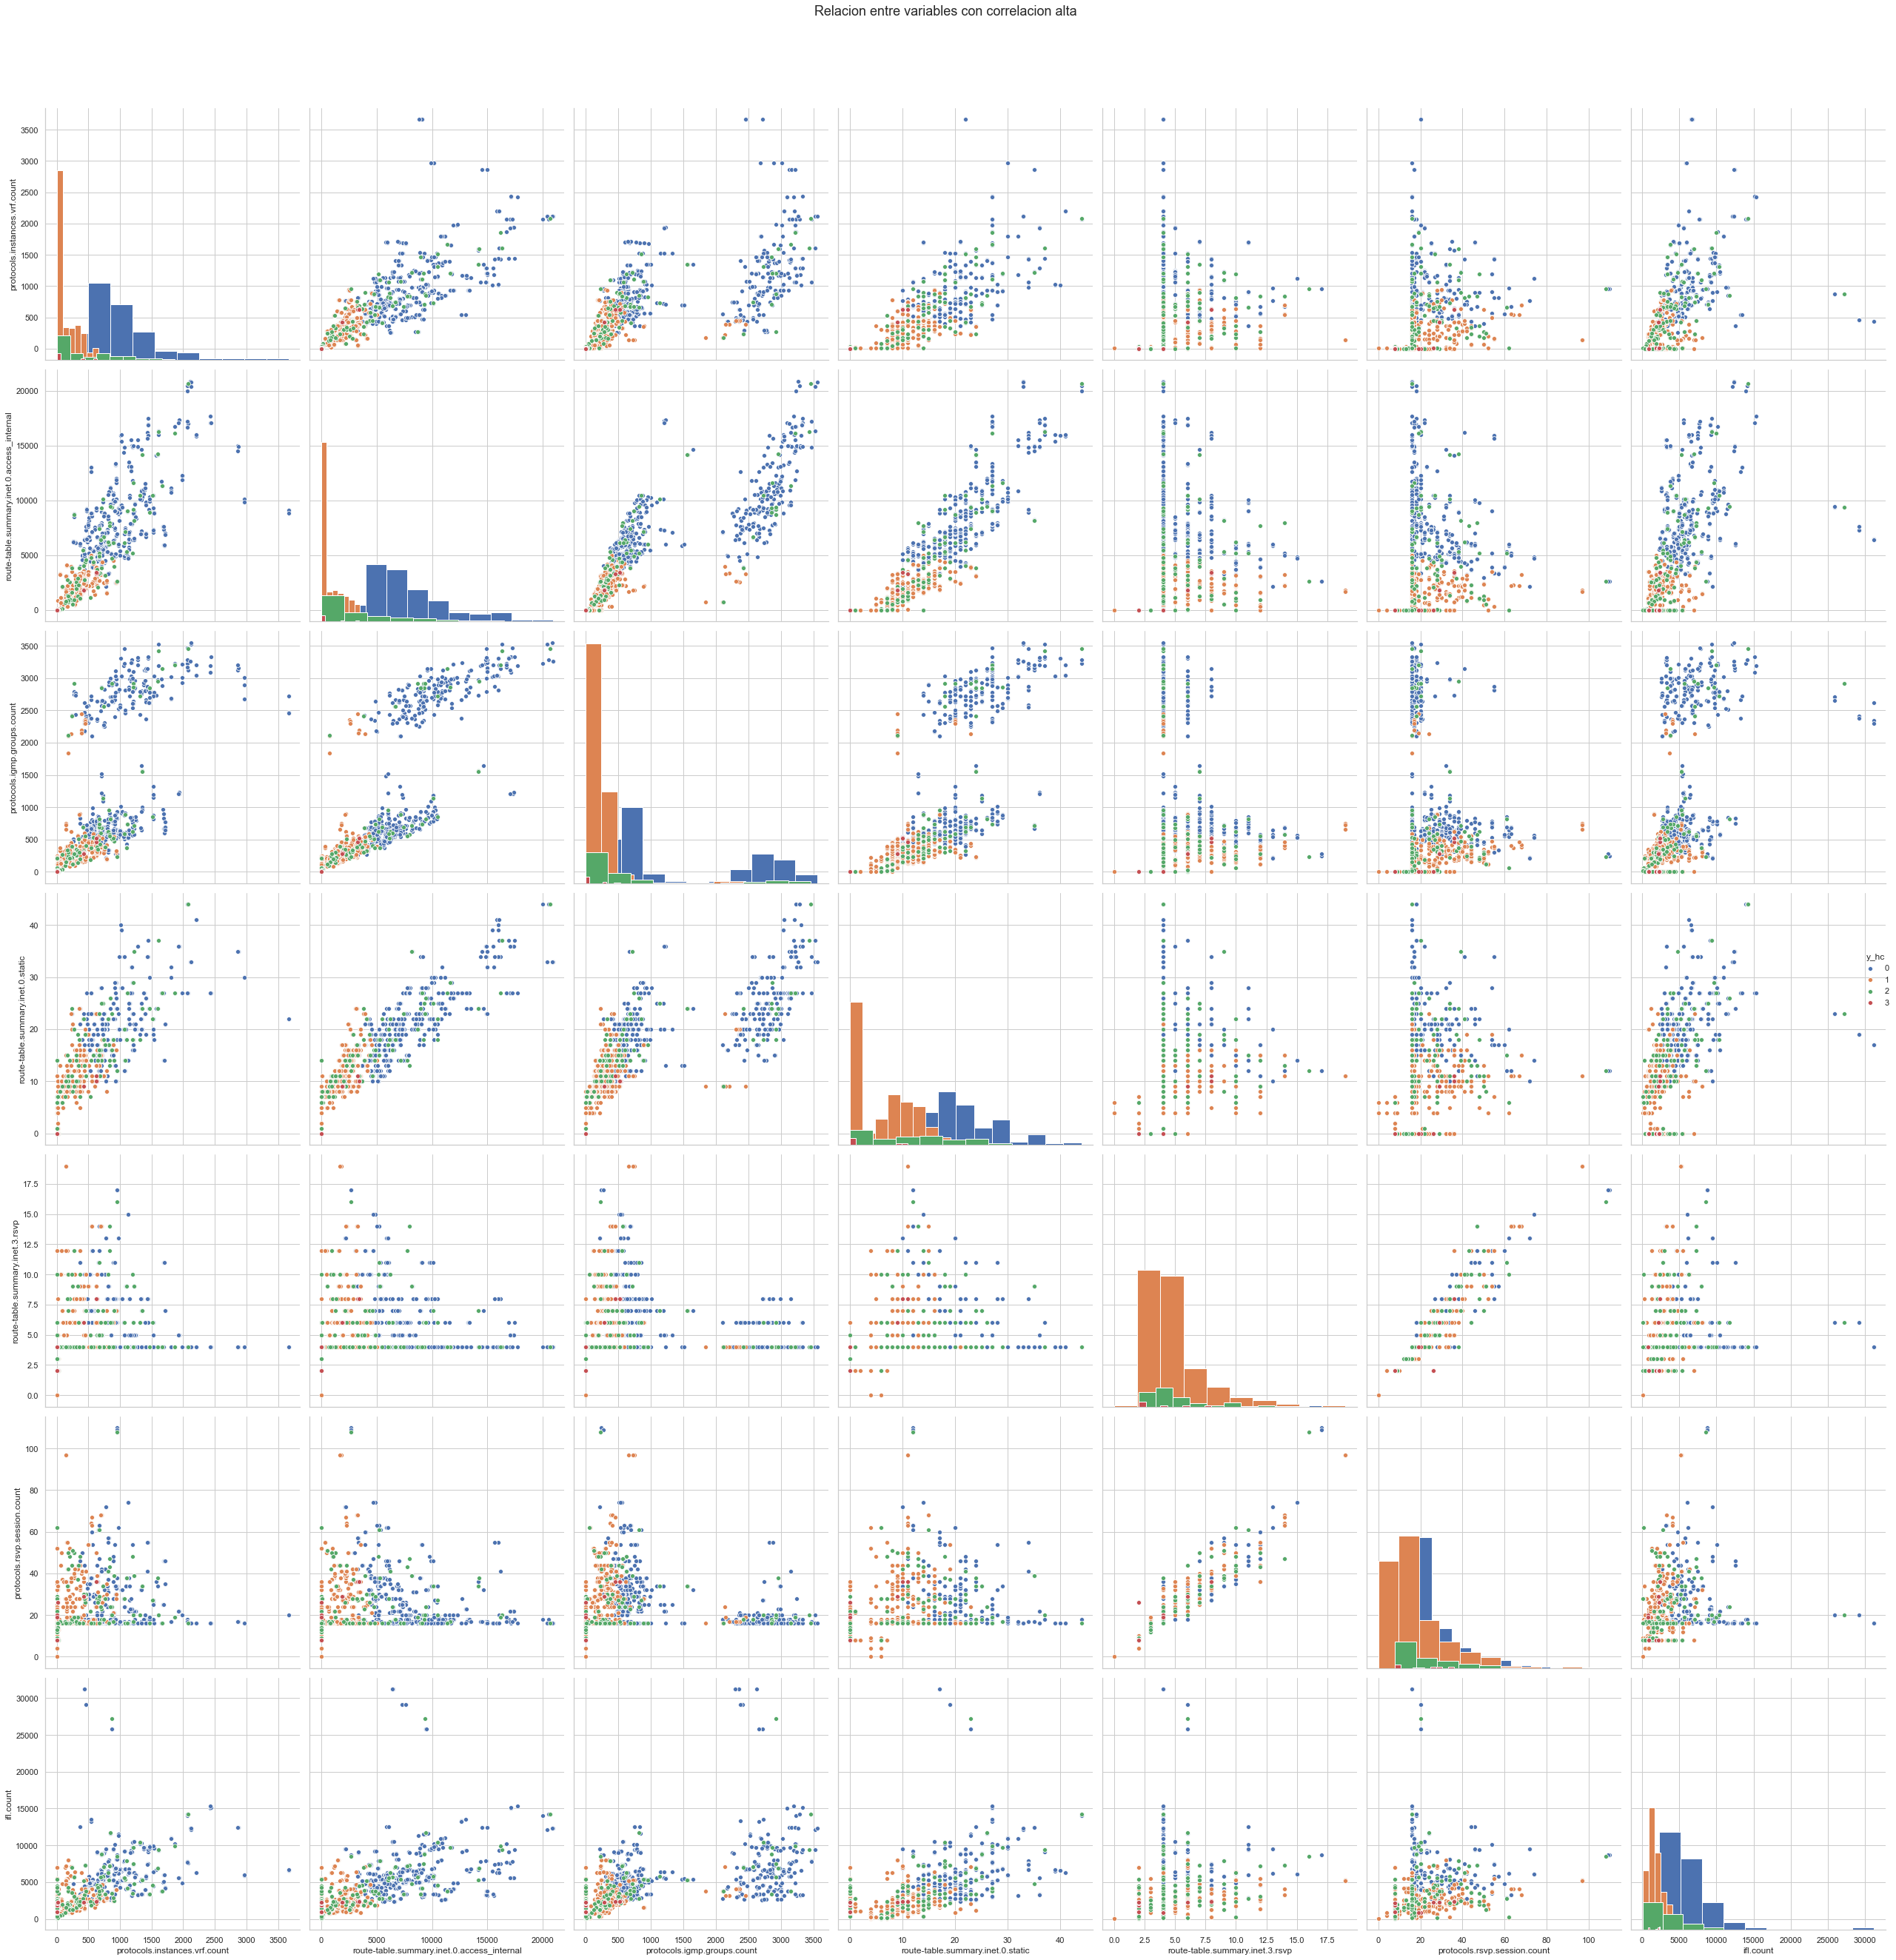

In [88]:
columns_to_review = top_features
sns.set(style="whitegrid" , palette="deep")
g = sns.pairplot(df_sample, vars=columns_to_review, hue='y_hc', kind='scatter', diag_kind='hist', height=5, aspect=1 )
plt.tight_layout()
g.fig.suptitle("Relacion entre variables con correlacion alta", fontsize=18, y=1.05);


In [89]:
profiling = df_sample.groupby('y_hc').agg(['mean'])

In [90]:
profiling[top_features]

,protocols.instances.vrf.count,route-table.summary.inet.0.access_internal,protocols.igmp.groups.count,route-table.summary.inet.0.static,route-table.summary.inet.3.rsvp,protocols.rsvp.session.count,ifl.count
,mean,mean,mean,mean,mean,mean,mean
y_hc,,,,,,,
0,969.010309,7913.247423,1438.754639,20.903093,5.915464,26.035052,6248.752577
1,164.605000,976.067500,173.678750,6.280000,4.251250,19.327500,1927.675000
2,441.532787,3484.442623,618.909836,11.385246,4.901639,22.491803,3580.401639
3,154.333333,751.190476,113.285714,2.761905,3.714286,19.190476,1826.142857


In [91]:
# Observando el pairplot, no es facil identificar con reglas sencillas los rangos de valores de estas variables
# que puedan identificar univocamente a cada grupo.

# Por lo que optaremos por utilizar un clasificador (en este caso un knn) que una vez entrenado con este dataset
# y la agrupacion obtenida con el AgglomerativeClustering, sea capaz de asignar a nuevos dispositivos en uno de estos
# grupos

### Entrenamiento y Evaluacion del clasificador - KNN <a name="knn_clasificador"/>

In [92]:
## Una vez hemos obtenido el numero de clusters mediante el aglomerativo jerarquico , 
## usamos un KNN para clasificar los nuevos datos en uno de estos grupos

In [93]:
# Generamos el datasetX

dataset_class_X = df_sample.loc[:, df_sample.columns != 'y_hc']

In [94]:
# Generamos el dataset_class_y
dataset_class_y = df_sample['y_hc'].to_numpy()

In [95]:
# Generamos el conjunto de entrenamiento y test teniendo el cuenta el desbalanceo
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(dataset_class_X, dataset_class_y, test_size=.3, random_state=42, stratify=dataset_class_y)

In [96]:
# Comprobamos que mantenemos las proporciones de las etiquetas entre entrenamiento y test

In [97]:
np.bincount(y_class_train)/len(y_class_train)

array([0.33933934, 0.56056056, 0.08508509, 0.01501502])

In [98]:
np.bincount(y_class_test)/len(y_class_test)

array([0.34032634, 0.55944056, 0.08624709, 0.01398601])

#### Hiperparametrizacion del modelo de KNN

In [99]:
# Iteramos con el valor de k, para encontrar el que mejor resultado obtenga

val_errors = []
t = list(reversed(range(1, 50, 2)))
np.random.seed(123)
for n in t:
    accuracy_cv = cross_val_score(KNeighborsClassifier(n_neighbors=n), X_class_train, y_class_train, cv=5,scoring='accuracy').mean()
    val_errors.append(1-accuracy_cv)

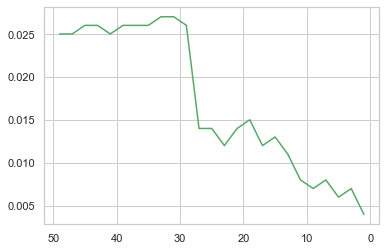

In [100]:
plt.plot(t, val_errors, 'g')
plt.gca().invert_xaxis()
plt.show()

In [101]:
# Valor optimo del parametro n_neighbors
optimal_neigh = 50-np.argmin(val_errors)*2
optimal_neigh

2

#### Entrenamiento y evaluacion del modelo 

In [102]:
knn_opt = KNeighborsClassifier(n_neighbors=optimal_neigh)
knn_opt.fit(X_class_train,y_class_train)
y_hat = knn_opt.predict(X_class_test)

In [103]:
# Accuracy : Acierto global del clasificador - Al tener un dataset desbalanceado el accuracy no es una metrica confiable
# Precision : Cuando predice la clase X , ¿con qué frecuencia es correcto? - Metrica mas confiable en dataset desbalanceados
# Recall: Cuando en realidad es la clase X , ¿con qué frecuencia es correcto? - Ratio de verdaderos positivos
# F1: Media armonica de la precision y el recall

print("Accuracy sobre el conjunto de test final: {}".format(accuracy_score(y_class_test,y_hat)))
print("Precision sobre el conjunto de test final: {}".format(precision_score(y_class_test, y_hat,average=None)))
print("Recall sobre el conjunto de test final: {}".format(recall_score(y_class_test, y_hat,average=None)))
print("F1 sobre el conjunto de test final: {}".format(f1_score(y_class_test, y_hat,average=None)))

Accuracy sobre el conjunto de test final: 0.993006993006993
Precision sobre el conjunto de test final: [0.97986577 1.         1.         1.        ]
Recall sobre el conjunto de test final: [1.     0.9875 1.     1.    ]
F1 sobre el conjunto de test final: [0.98983051 0.99371069 1.         1.        ]


(4.0, -1.0)

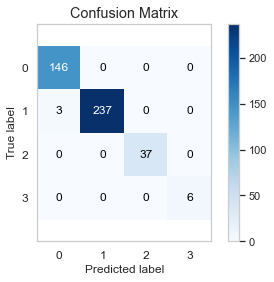

In [104]:
# Generamos una matriz de confusion para ver mas claramente los resultados
y_class_predicted = knn_opt.predict(X_class_test)
ax = skplt.metrics.plot_confusion_matrix(y_class_test, y_class_predicted)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

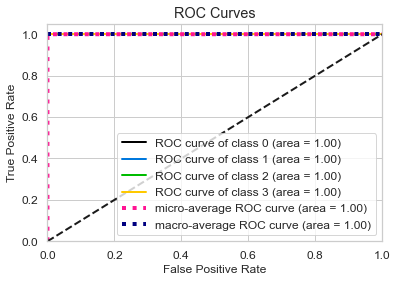

In [105]:
# Curva ROC
# Esta curva nos permite visualizar la compensación entre la tasa de verdaderos positivos y la tasa de falsos positivos
skplt.metrics.plot_roc(y_class_test, knn_opt.predict_proba(X_class_test))
plt.show()

In [106]:
# Con estos resultados del modelo clasificador KNN podemos posteriormente utilizarlo en el
# entorno de produccion para que el usuario cuando introduzca los paramentros de entrada al 
# modelo, y se le estimen los consumos, adicionalmente se le pueda indicar en que grupo
# podria clasificarse su estimacion.

## Prueba de concepto y Pase a produción  <a name="producion"/>

In [107]:
# Salvamos el modelo random forest parametrizado a disco, 
# para poder ser utilizado por la app
filename = 'modelo_final.sav'
pickle.dump(rfr_best, open(filename, 'wb'))

In [108]:
# Salvamos el modelo knn a disco
filename_class = 'modelo_final_class.sav'
pickle.dump(knn_opt, open(filename_class, 'wb'))

En el siguiente link se puede hacer una simulacion de resultados:

Instalar el siguiente paquete:

!pip install streamlit

Ejecutar en el terminal: 

##### streamlit run web_app.py -- Se abrira automaticamente el navegador en la URL http://localhost:8501

en caso contrario hacer click en el siguiente enlace:


[PORTAL WEB](http://localhost:8501)

## Conclusiones <a name="Conclusiones"/>

In [109]:
# Una vez terminado todo este proceso podemos decir que contamos con un modelo capaz de hacer las estimaciones
# de los recursos de red, y que se encuentra lista para ser utilizada por el usuario final via el portal web.

# Hemos pasado por varias fases desde la recopilacion de los datos, el procesado y posterior 
# estudio, para luego poder a partir de alli entrenar un modelo y parametrizarlo para minimizar el error, contrastando
# varios mecanismos o metricas para evaluar el error del modelo.

# En nuestro escenario el tiempo invertido para la hiperparametrizacion compensa, puesto que se ha logrado 
# disminuir el error con respecto al modelo base.  Si se tratara de un entorno tiempo real, pues igual esta opcion
# no es viable

In [110]:
# Puntos de mejora.

# - Buscar otras aproximaciones para realizar el profiling.
# - Optimizar el proceso de hiperparametrizacion para disminuir el consumo de recursos durante el calculo.
# - Empaquetar en funciones / clases los procesos seguidos y crear un pipeline
# - Aumentar el dataset de pruebas con informacion de otros escenarios y verificar si este modelo sigue siendo valido.
# - Reducir algo mas la dimensionalidad de las variables de entrada.